In [1]:
import numpy as np
import doubleml as dml
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from doubleml.datasets import make_plr_CCDDHNR2018, make_irm_data
from sklearn.base import clone

from scipy import stats

from utils import make_data_list, simulate_gb_plr, make_BCH2014_data_list,\
                  plot_gb_plr_variation_results, plot_bias_coverage_next_to_eachother,\
                  plot_gb_irm_variation_results

np.random.seed(1312)

# 1. Create Data

## 1.1 DGB based on CCDDHNR2018

In [2]:
n_rep = 500
n_obs = 500
n_vars = 20
alpha = 0.5

data = make_data_list(n_rep=n_rep, n_obs=n_obs, n_vars=n_vars, model_type='plr', alpha=alpha)

## 1.2 DGB based on BCH2014

In [3]:
n_rep_BCH14 = 300
theta_BCH14 = 0.5 
n_obs_BCH14 = 100
dim_x_BCH14 = 200 
rho_BCH14 = 0.5
R2_d_BCH14 = 0.5 
R2_y_BCH14 = 0.5 
design_BCH14 = '1a'

random_seed_BCH14 = 1312

data_BCH14 = make_BCH2014_data_list(n_rep=n_rep_BCH14, theta=theta_BCH14, n_obs=n_obs_BCH14, dim_x=dim_x_BCH14,
                                    rho=rho_BCH14, R2_d=R2_d_BCH14, R2_y=R2_y_BCH14, design=design_BCH14, random_seed=random_seed_BCH14)

## 1.3 IRM Data

In [4]:
n_rep_irm = 300
n_obs_irm = 400
n_vars_irm = 250
R2_y_irm = 0.5
R2_d_irm = 0.5
alpha_irm = 0.5

irm_data = make_data_list(n_rep=n_rep_irm, n_obs=n_obs_irm, n_vars=n_vars_irm,
                          R2_y=R2_y_irm, R2_d=R2_d_irm, model_type='irm', alpha=alpha_irm)

# 2. Finding Optimal Hyperparameter Combination

In [5]:
gb_regression_hyperparameters = dict(
    loss = ['squared_error', 'huber', 'quantile'],
    learning_rate = [0.001, 0.01, 0.1, 1],
    n_estimators = [10, 100, 1000],
    subsample = [0.9, 1],
    min_samples_split = [0.01, 0.1, 0.5],
    min_samples_leaf = [2, 5, 10]
)

## 2.1 Gradient Boosting Regressor (PLR)

In [6]:

np.random.seed(1312)

(x, y, d) = make_plr_CCDDHNR2018(n_obs=n_obs, n_vars=n_vars, return_type='array')
search_dml_plr_data = dml.DoubleMLData.from_arrays(x, y, d)

ml_l = GradientBoostingRegressor()
ml_m = GradientBoostingRegressor()

dml_gb_regression = {
    "ml_l": gb_regression_hyperparameters,
    "ml_m": gb_regression_hyperparameters
}

gb_dml_plr_obj = dml.DoubleMLPLR(
    search_dml_plr_data, ml_l, ml_m, n_folds=5,
    score='partialling out', apply_cross_fitting=True
)

# using DoubleML tune() method for grid/randomized search
gb_dml_plr_obj.tune(dml_gb_regression, search_mode='randomized_search')
print(gb_dml_plr_obj.fit(store_models=True).summary)

       coef   std err          t         P>|t|     2.5 %    97.5 %
d  0.529257  0.038088  13.895736  6.722895e-44  0.454607  0.603908


In [7]:
ml_l_plr_model_list = gb_dml_plr_obj.models['ml_l']['d'][0]
ml_l_plr_gb_model = max(set(ml_l_plr_model_list), key=ml_l_plr_model_list.count)
ml_m_plr_model_list = gb_dml_plr_obj.models['ml_m']['d'][0]
ml_m_plr_gb_model = max(set(ml_m_plr_model_list), key=ml_l_plr_model_list.count)

print(f"ml_l model: {ml_l_plr_gb_model}\nml_m model: {ml_m_plr_gb_model}")

ml_l model: GradientBoostingRegressor(learning_rate=0.01, loss='huber', min_samples_leaf=10,
                          min_samples_split=0.5, n_estimators=1000,
                          subsample=0.9)
ml_m model: GradientBoostingRegressor(loss='huber', min_samples_leaf=5,
                          min_samples_split=0.5, subsample=0.9)


## 2.2 Gradient Boosting Classifier (IRM)

In [8]:
gb_classification_hyperparameters = dict(
    loss = ['log_loss', 'exponential'],
    learning_rate = [0.001, 0.01, 0.1, 1],
    n_estimators = [10, 100, 1000],
    subsample = [0.9, 1],
    min_samples_split = [0.01, 0.1, 0.5],
    min_samples_leaf = [2, 5, 10]
)

np.random.seed(1312)

(x, y, d) = make_irm_data(n_obs=n_obs_irm, dim_x=n_vars_irm, return_type='array')
search_dml_irm_data = dml.DoubleMLData.from_arrays(x, y, d)

ml_l = GradientBoostingRegressor()
ml_m = GradientBoostingClassifier()

dml_gb_classification = {
    "ml_g": gb_regression_hyperparameters,
    "ml_m": gb_classification_hyperparameters
}

gb_dml_irm_obj = dml.DoubleMLIRM(
    search_dml_irm_data, ml_l, ml_m, n_folds=5,
    score='ATE', apply_cross_fitting=True
)

# using DoubleML tune() method for grid/randomized search
gb_dml_irm_obj.tune(dml_gb_classification, search_mode='randomized_search')
print(gb_dml_irm_obj.fit(store_models=True).summary)

       coef   std err         t     P>|t|     2.5 %   97.5 %
d  0.135988  0.106916  1.271919  0.203402 -0.073563  0.34554


In [9]:
ml_g0_irm_model_list = gb_dml_irm_obj.models['ml_g0']['d'][0]
ml_g0_irm_gb_model = max(set(ml_g0_irm_model_list), key=ml_g0_irm_model_list.count)
ml_g1_irm_model_list = gb_dml_irm_obj.models['ml_g1']['d'][0]
ml_g1_irm_gb_model = max(set(ml_g1_irm_model_list), key=ml_g1_irm_model_list.count)
ml_m_irm_model_list = gb_dml_irm_obj.models['ml_m']['d'][0]
ml_m_irm_gb_model = max(set(ml_m_irm_model_list), key=ml_m_irm_model_list.count)

print(f"ml_g0 model: {ml_g0_irm_gb_model}\nml_g1 model: {ml_g1_irm_gb_model}\nml_m model: {ml_m_irm_gb_model}")

ml_g0 model: GradientBoostingRegressor(learning_rate=0.001, loss='huber', min_samples_leaf=5,
                          min_samples_split=0.01, n_estimators=10, subsample=1)
ml_g1 model: GradientBoostingRegressor(learning_rate=0.01, loss='huber', min_samples_leaf=5,
                          min_samples_split=0.1, n_estimators=1000,
                          subsample=0.9)
ml_m model: GradientBoostingClassifier(learning_rate=0.01, loss='exponential',
                           min_samples_leaf=10, min_samples_split=0.5,
                           subsample=1)


# 3. PLR Simulation and Hyperparameter Variation

## 3.1 Number of Estimators Variation

In [10]:
def plot_gradient_boosting_score(ml_l, ml_m, theta_scores, se_scores, alpha, hyperparameter: str):
    
    face_colors = sns.color_palette('pastel')
    edge_colors = sns.color_palette('dark')

    plt.figure(constrained_layout=True)
    plt.title(f'Gradient Boosting: \n' + f'${hyperparameter}' + '_{m_{0}(x)}$' + f'={ml_m.n_estimators}'
            '\n' + f'${hyperparameter}' + '_{g_{0}(x)}$' + f'={ml_l.n_estimators}')
    ax = sns.histplot((theta_scores - alpha)/se_scores,
                    color=face_colors[2], edgecolor = edge_colors[2],
                    stat='density', bins=30, label='Double ML GB')
    ax.axvline(0., color='k')

    xx = np.arange(-5, +5, 0.001)
    yy = stats.norm.pdf(xx)

    ax.plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$')
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
    ax.set_xlim([-6., 6.])
    ax.set_xlabel('$(\hat{\\theta}_0 - \\theta_0)/\hat{\sigma}$')
    plt.show()

Distributions calculated: 1
Distributions calculated: 2
Distributions calculated: 3
Distributions calculated: 4
Distributions calculated: 5
Distributions calculated: 6
Distributions calculated: 7
Distributions calculated: 8
Distributions calculated: 9


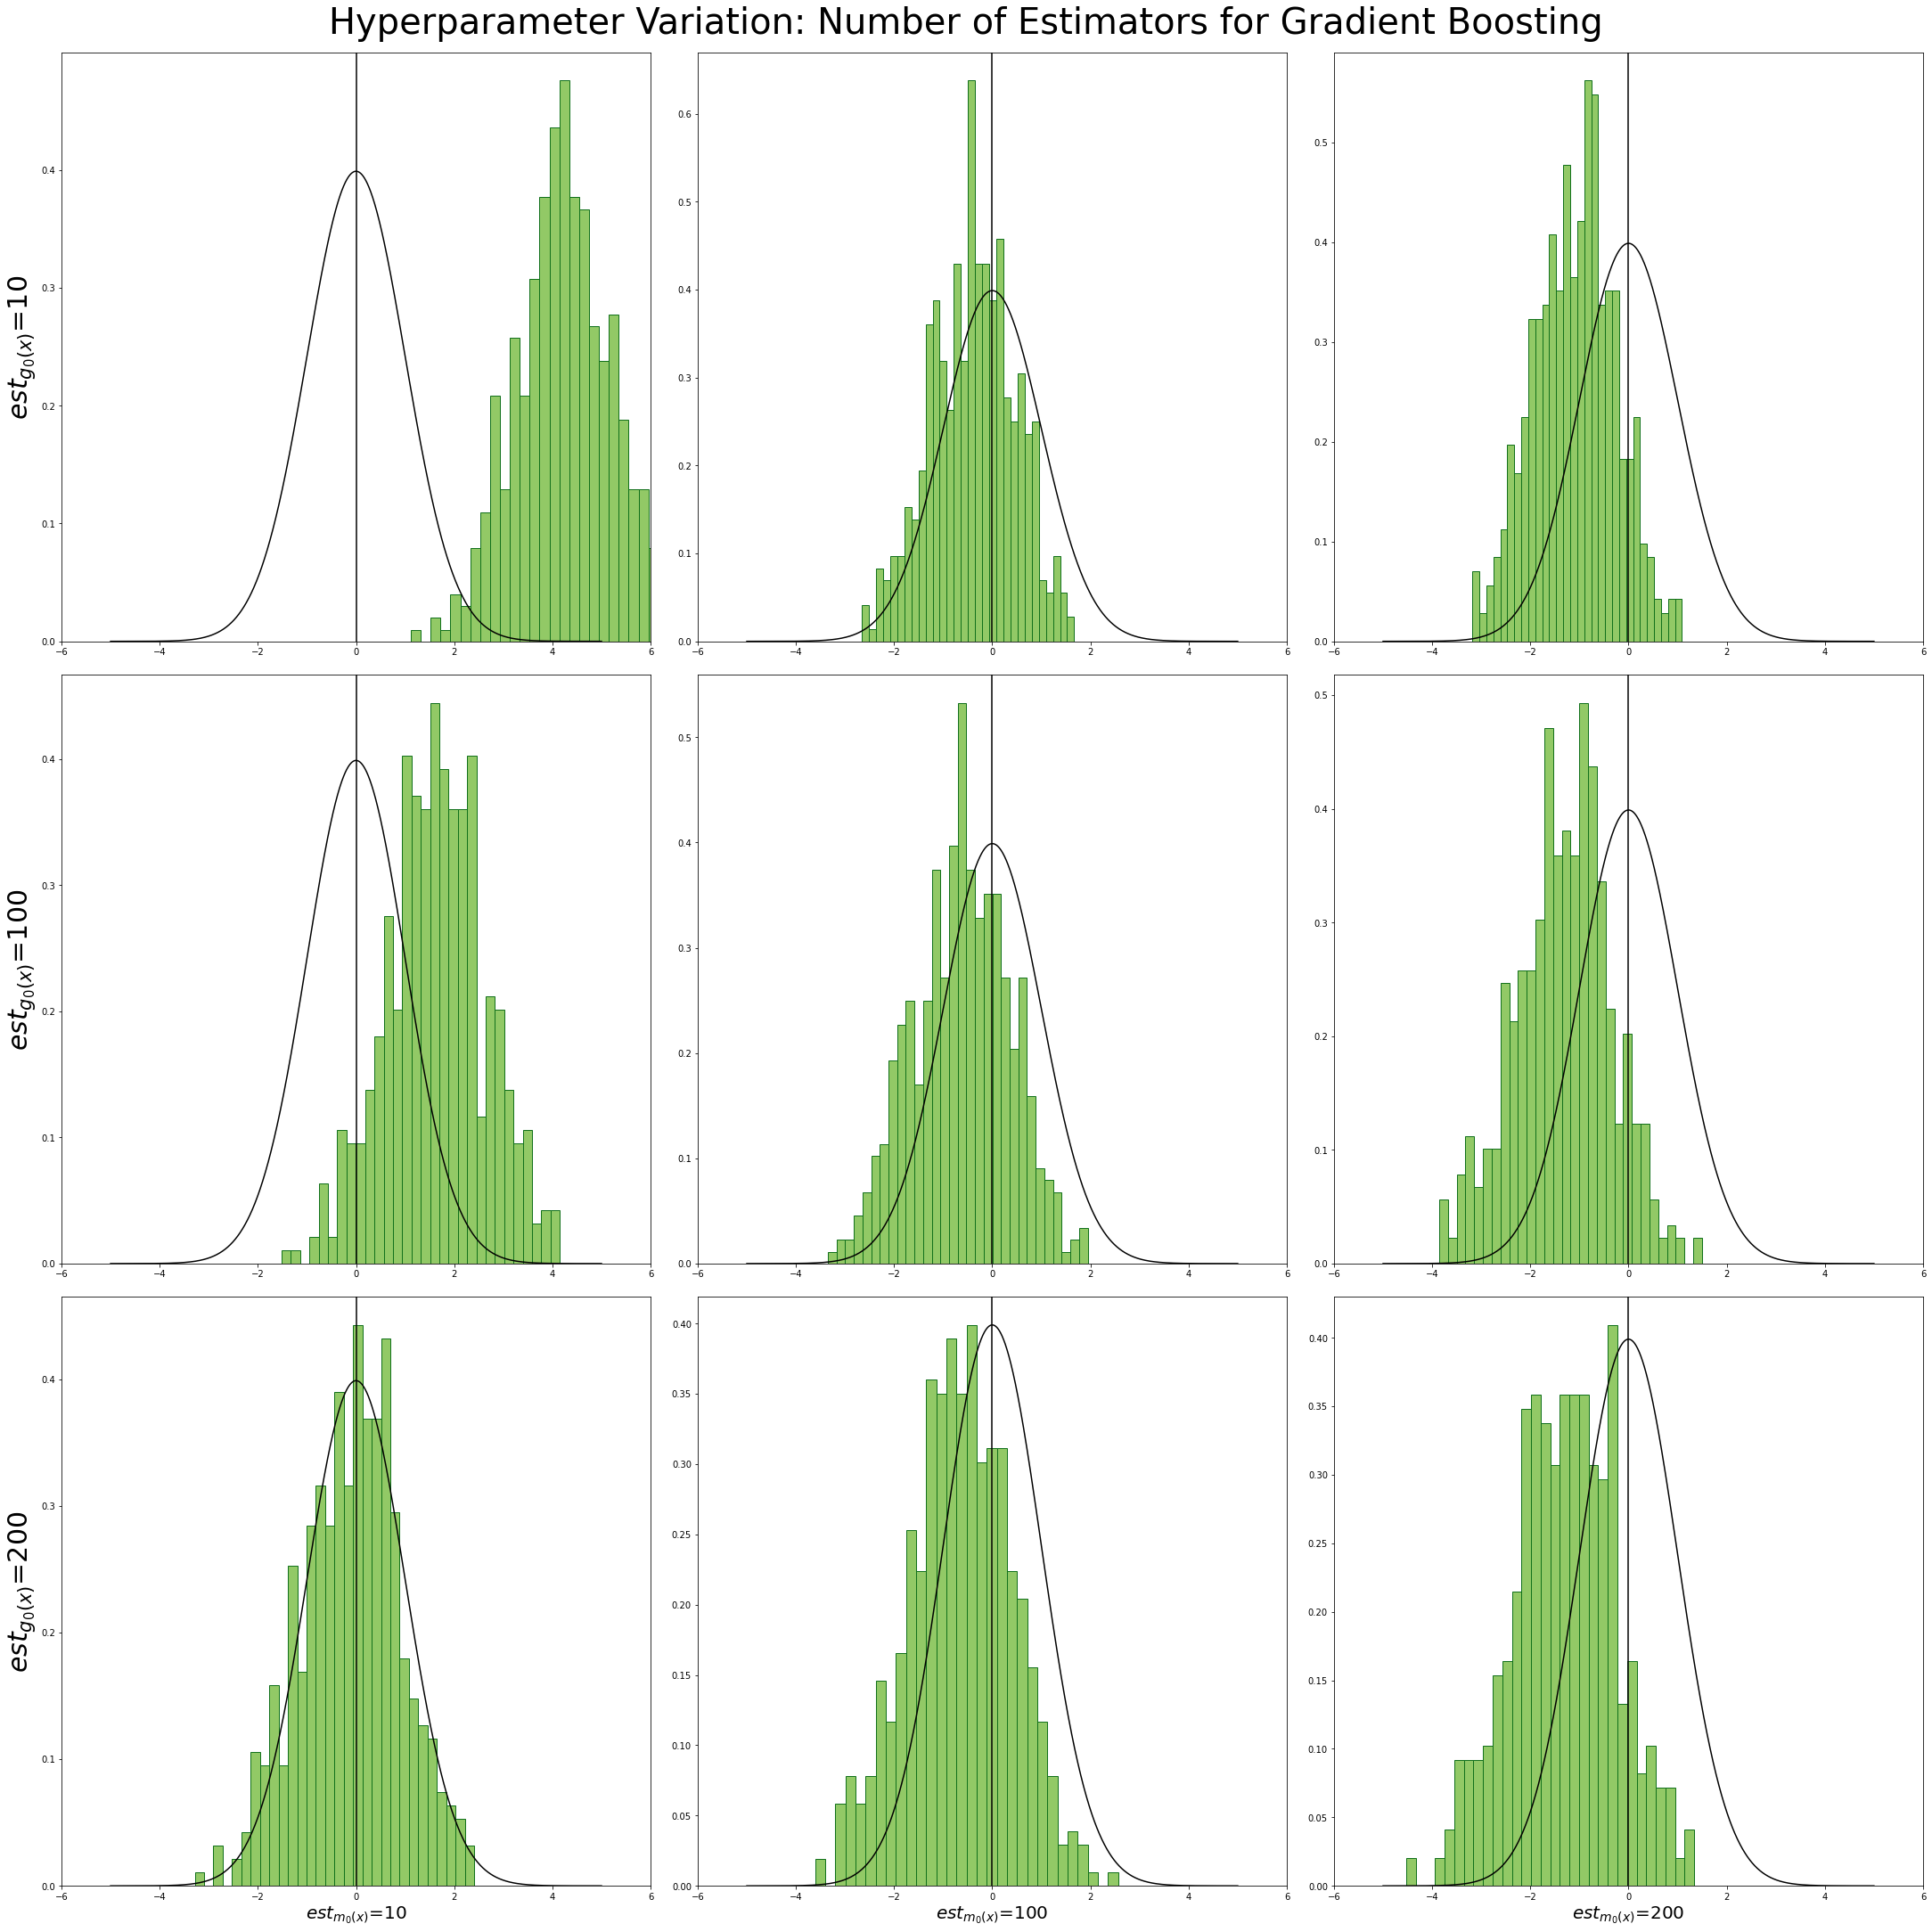

In [11]:
gb_n_est_hyperparams_ml_l = [10, 100, 200]
gb_n_est_hyperparams_ml_m = [10, 100, 200]

n_folds=5

n_est_coverage, n_est_bias = plot_gb_plr_variation_results(ml_l_hyperparameters=gb_n_est_hyperparams_ml_l,
                                                           ml_m_hyperparameters=gb_n_est_hyperparams_ml_m,
                                                           n_folds=n_folds, data=data, true_alpha=alpha,
                                                           tunable_hyperparameter='n_estimators', 
                                                           ml_l_model=ml_l_plr_gb_model,
                                                           ml_m_model=ml_m_plr_gb_model,
                                                           title="Hyperparameter Variation: Number of Estimators for Gradient Boosting",
                                                           xlabels='$est_{m_{0}(x)}$=', ylabel='$est_{g_{0}(x)}$=',
                                                           filename="gb_number_estimators_variation.png")

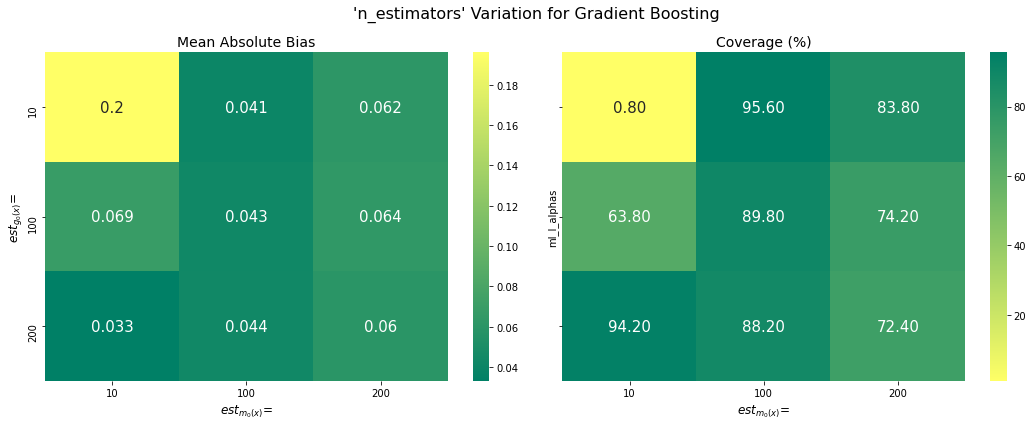

In [12]:
plot_bias_coverage_next_to_eachother(ml_l_hyperparameters=gb_n_est_hyperparams_ml_l, 
                                     ml_m_hyperparameters=gb_n_est_hyperparams_ml_m,
                                     bias_scores=n_est_bias,
                                     coverage_scores=n_est_coverage,
                                     suptitle=f"'n_estimators' Variation for Gradient Boosting",
                                     xlabel='$est_{m_{0}(x)}$=',
                                     ylabel='$est_{g_{0}(x)}$=',
                                     filename="gb_n_est_bias_coverage.png")

## 3.2 Minimum of Samples for Split Variation

Distributions calculated: 1
Distributions calculated: 2
Distributions calculated: 3
Distributions calculated: 4
Distributions calculated: 5
Distributions calculated: 6
Distributions calculated: 7
Distributions calculated: 8
Distributions calculated: 9


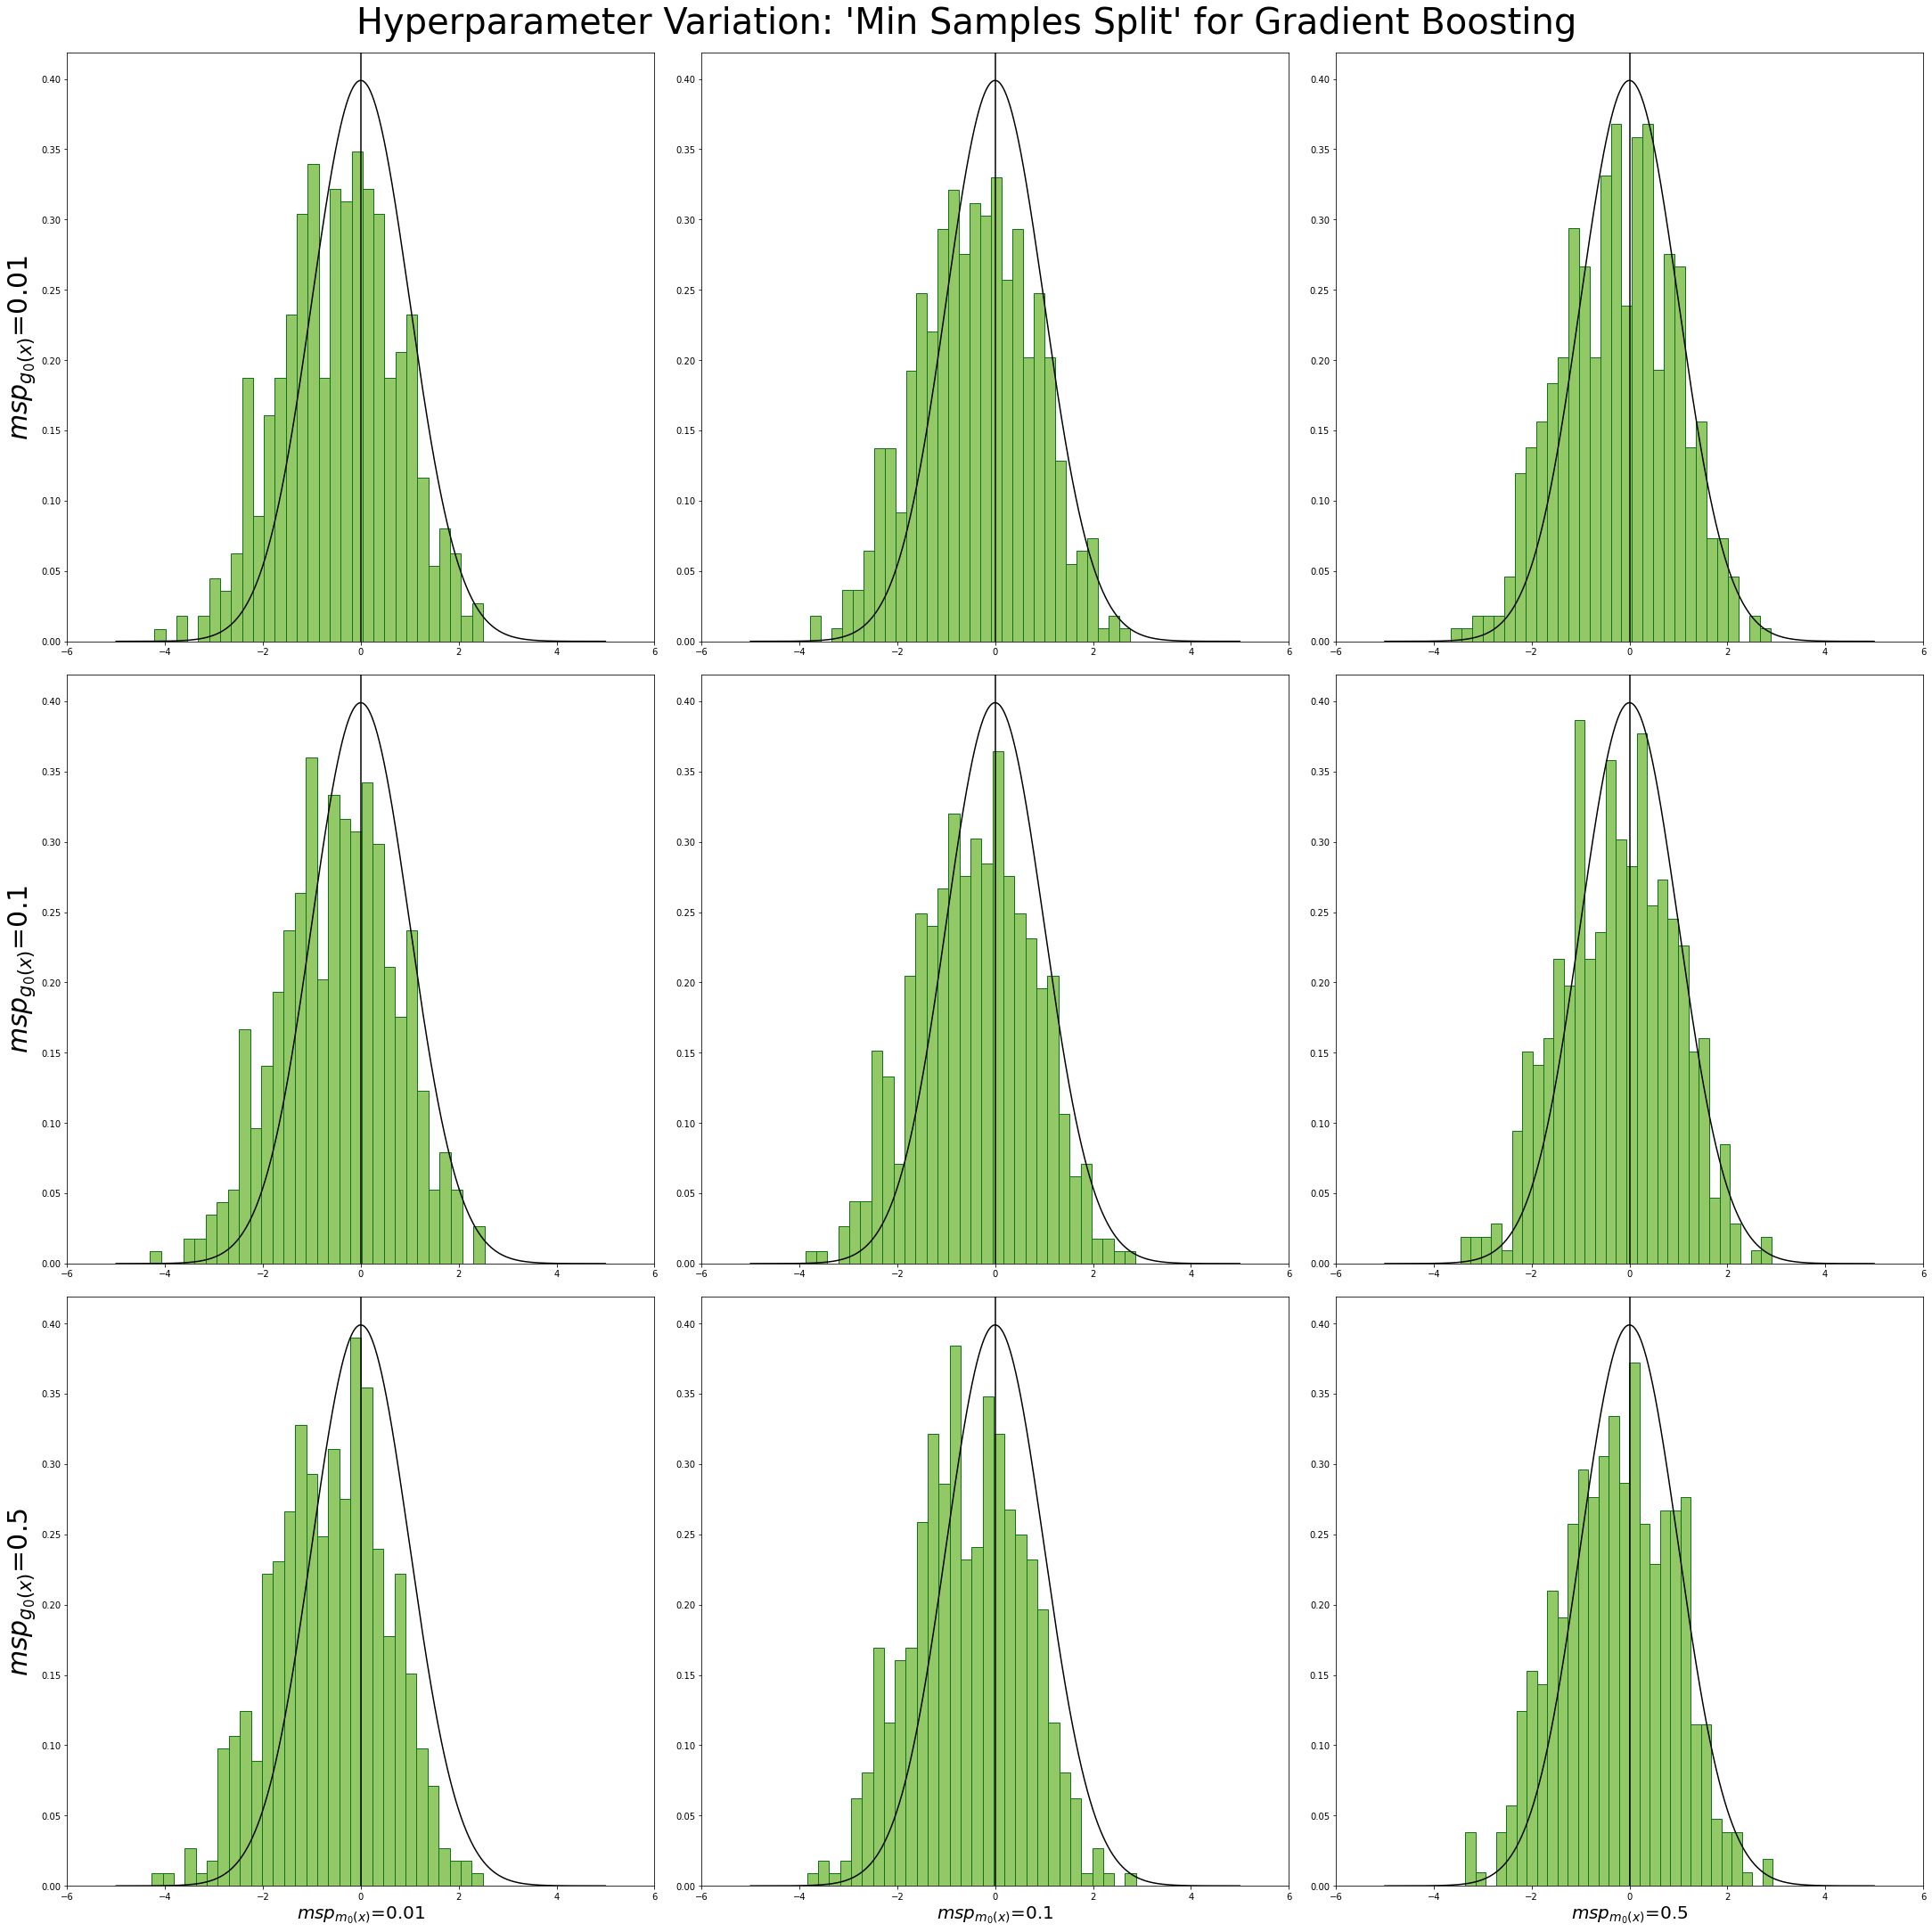

In [13]:
gb_min_samples_split_hyperparams_ml_l = [0.01, 0.1, 0.5]
gb_min_samples_split_hyperparams_ml_m = [0.01, 0.1, 0.5]
n_folds=5

min_sample_split_coverage, min_sample_split_bias = plot_gb_plr_variation_results(ml_l_hyperparameters=gb_min_samples_split_hyperparams_ml_l,
                                                                                 ml_m_hyperparameters=gb_min_samples_split_hyperparams_ml_m,
                                                                                 n_folds=n_folds, data=data, true_alpha=alpha,
                                                                                 tunable_hyperparameter='min_samples_split', 
                                                                                 ml_l_model=ml_l_plr_gb_model,
                                                                                 ml_m_model=ml_m_plr_gb_model,
                                                                                 title="Hyperparameter Variation: 'Min Samples Split' for Gradient Boosting",
                                                                                 xlabels='$msp_{m_{0}(x)}$=', ylabel='$msp_{g_{0}(x)}$=',
                                                                                 filename="gb_min_samples_split_variation.png")

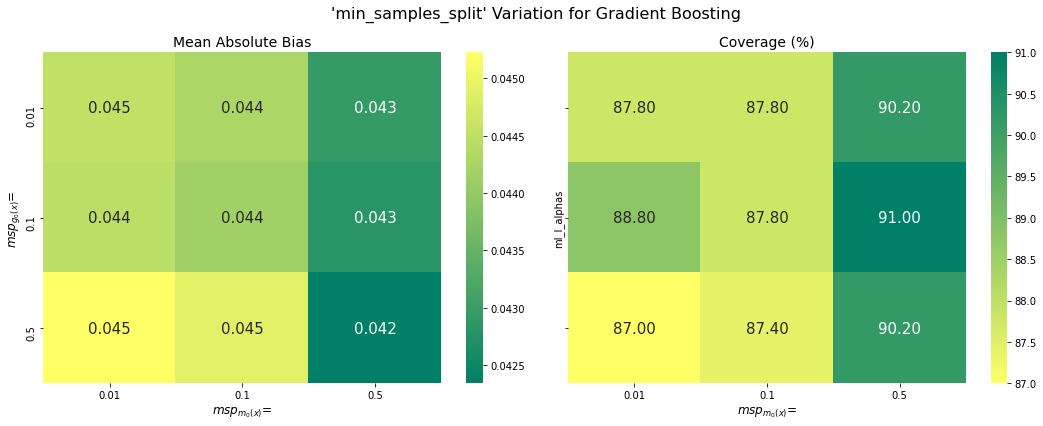

In [14]:
plot_bias_coverage_next_to_eachother(ml_l_hyperparameters=gb_min_samples_split_hyperparams_ml_l, 
                                     ml_m_hyperparameters=gb_min_samples_split_hyperparams_ml_m,
                                     bias_scores=min_sample_split_bias,
                                     coverage_scores=min_sample_split_coverage,
                                     suptitle=f"'min_samples_split' Variation for Gradient Boosting",
                                     xlabel='$msp_{m_{0}(x)}$=',
                                     ylabel='$msp_{g_{0}(x)}$=',
                                     filename="gb_min_samples_split_bias_coverage.png")

## 3.3 Learning Rate Variation

Distributions calculated: 1
Distributions calculated: 2
Distributions calculated: 3
Distributions calculated: 4
Distributions calculated: 5
Distributions calculated: 6
Distributions calculated: 7
Distributions calculated: 8
Distributions calculated: 9


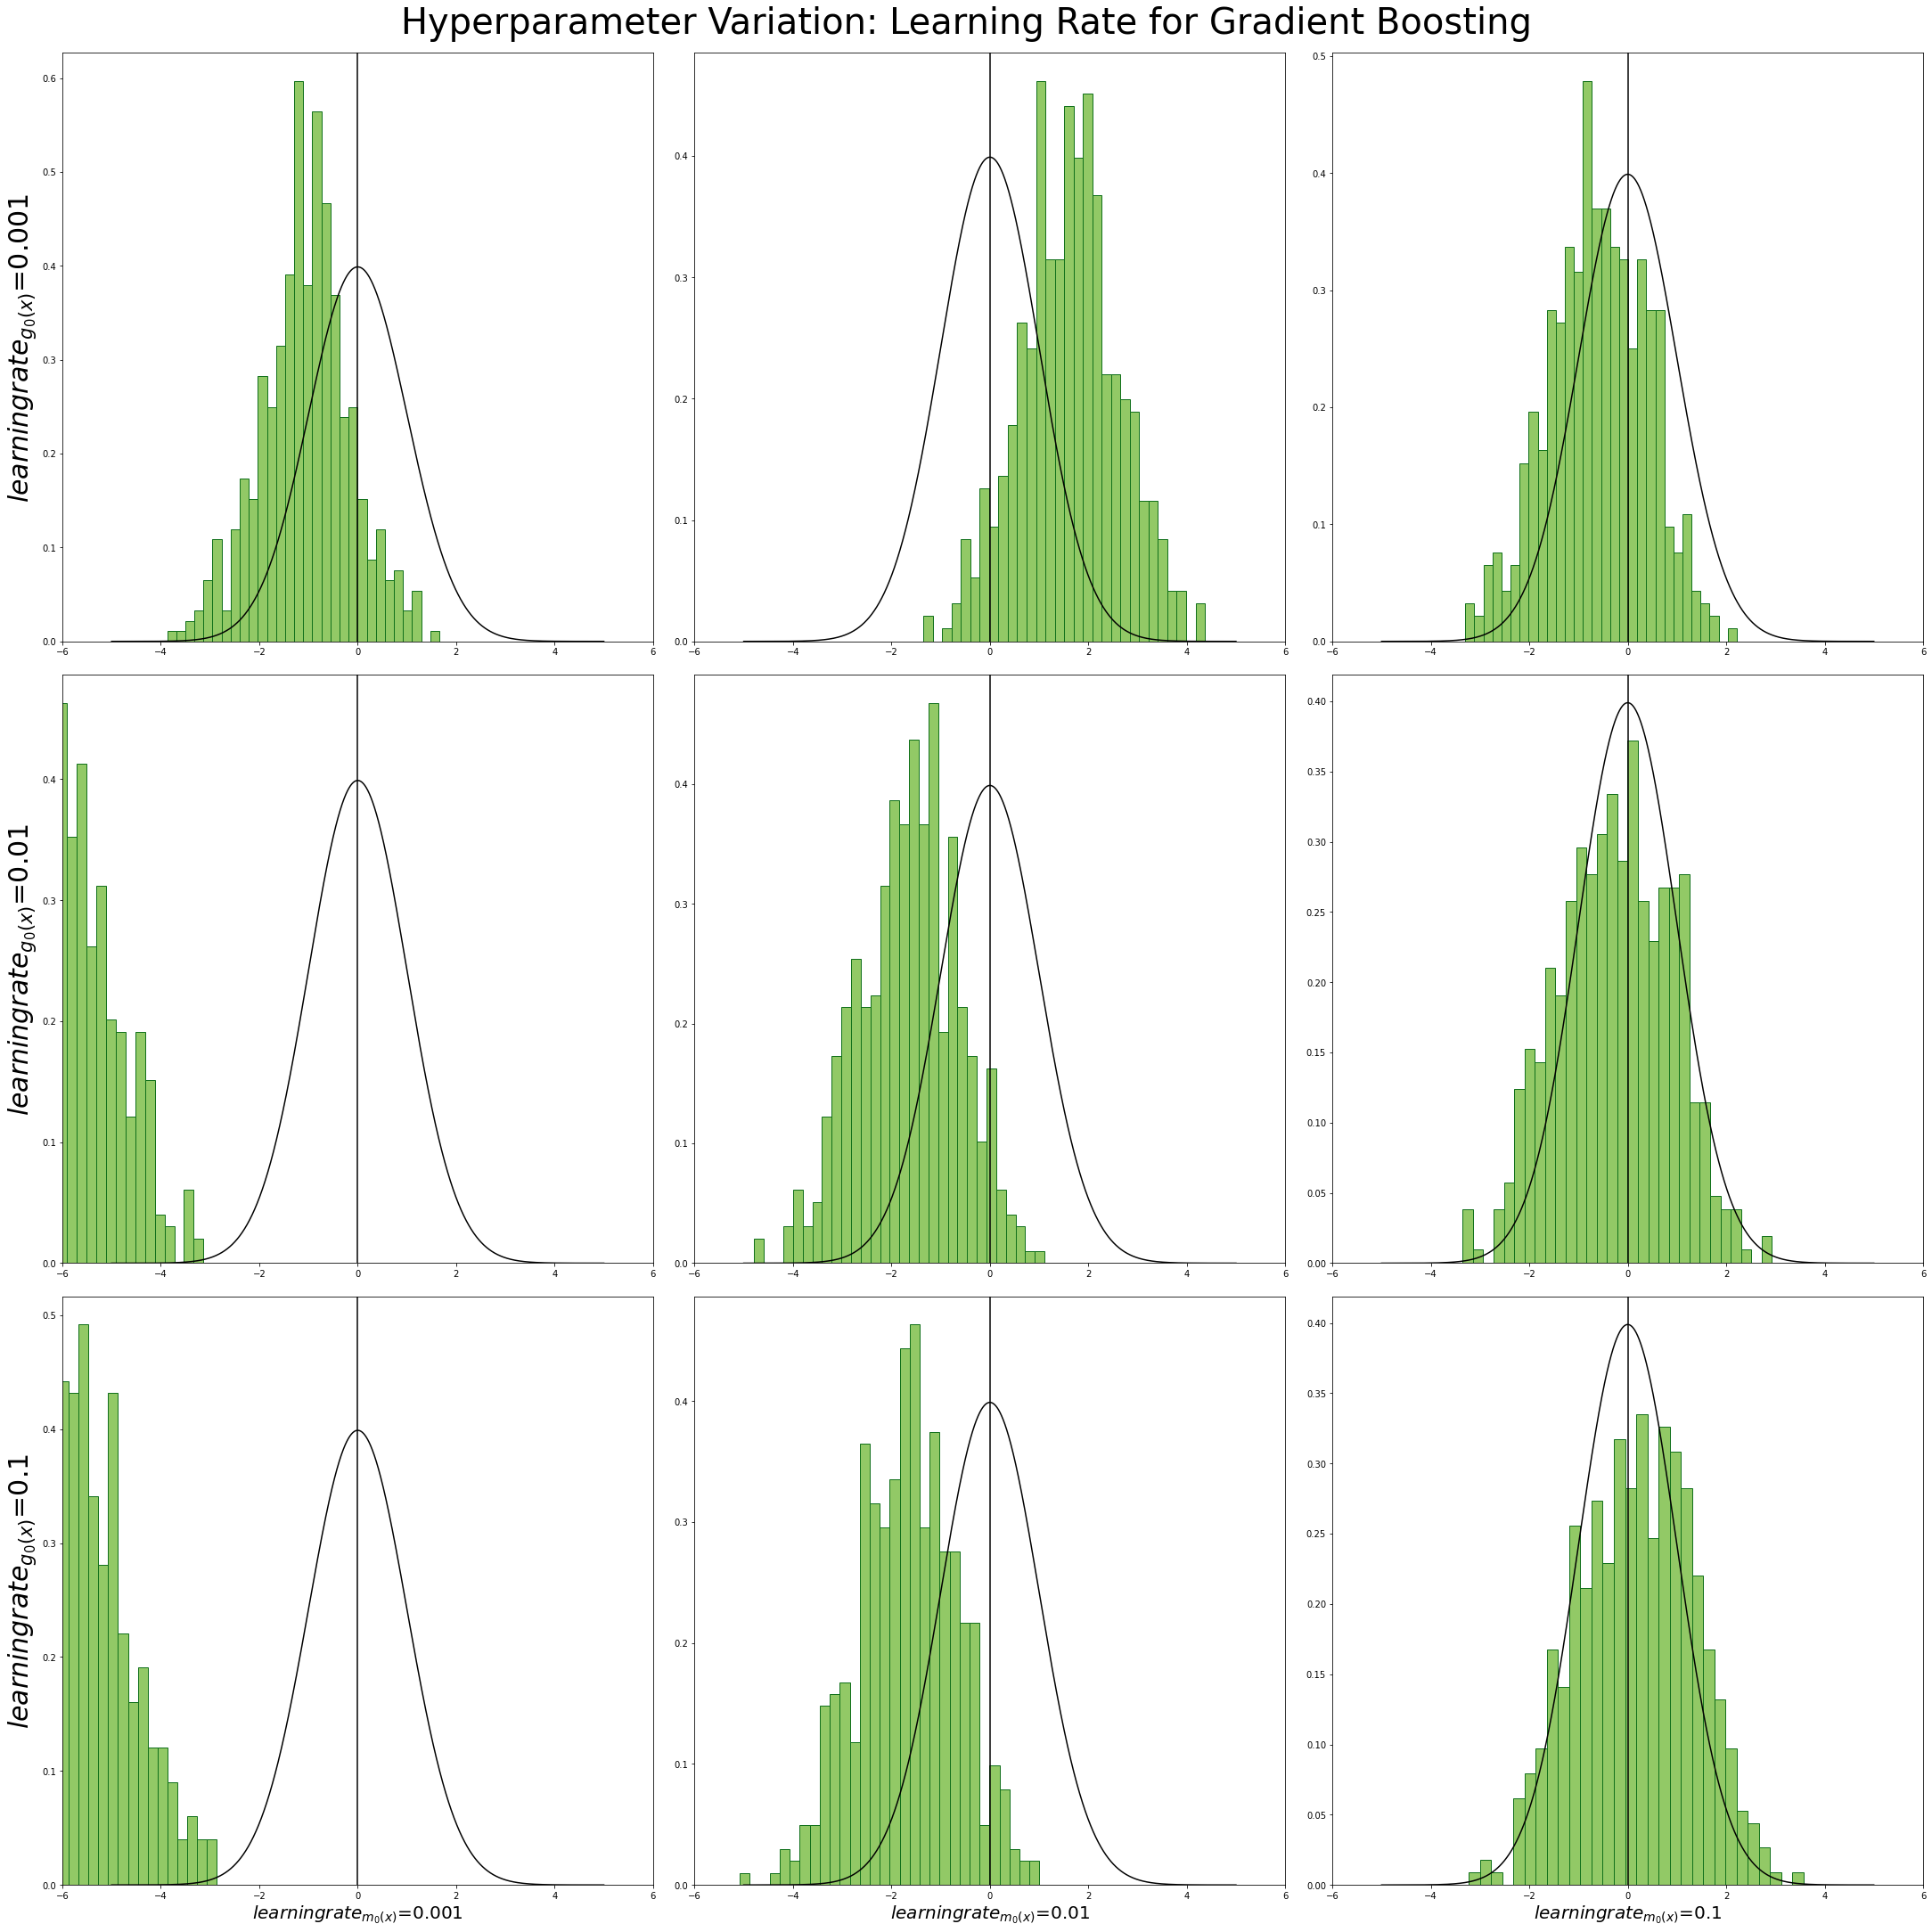

In [15]:
gb_learning_rate_hyperparams_ml_l = [0.001, 0.01, 0.1]
gb_learning_rate_hyperparams_ml_m = [0.001, 0.01, 0.1]
n_folds=5

learningrate_coverage, learningrate_bias = plot_gb_plr_variation_results(ml_l_hyperparameters=gb_learning_rate_hyperparams_ml_l,
                                                                         ml_m_hyperparameters=gb_learning_rate_hyperparams_ml_m,
                                                                         n_folds=n_folds, data=data, true_alpha=alpha,
                                                                         tunable_hyperparameter='learning_rate', 
                                                                         ml_l_model=ml_l_plr_gb_model,
                                                                         ml_m_model=ml_m_plr_gb_model,
                                                                         title="Hyperparameter Variation: Learning Rate for Gradient Boosting",
                                                                         xlabels='$learningrate_{m_{0}(x)}$=', ylabel='$learningrate_{g_{0}(x)}$=',
                                                                         filename="gb_learning_rate_variation.png")

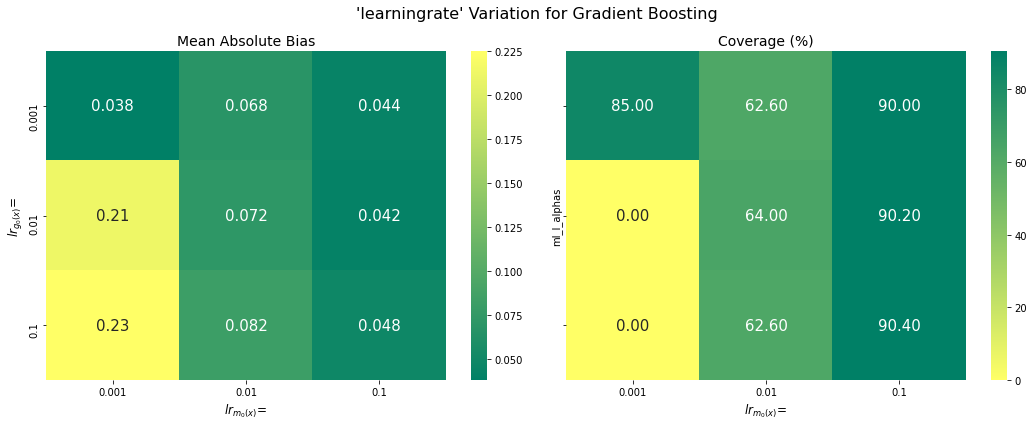

In [16]:
plot_bias_coverage_next_to_eachother(ml_l_hyperparameters=gb_learning_rate_hyperparams_ml_l, 
                                     ml_m_hyperparameters=gb_learning_rate_hyperparams_ml_m,
                                     bias_scores=learningrate_bias,
                                     coverage_scores=learningrate_coverage,
                                     suptitle=f"'learningrate' Variation for Gradient Boosting",
                                     xlabel='$lr_{m_{0}(x)}$=',
                                     ylabel='$lr_{g_{0}(x)}$=',
                                     filename="gb_learningrate_bias_coverage.png")

## 3.4 BCH2014: Number of Estimators Variation

Distributions calculated: 1
Distributions calculated: 2
Distributions calculated: 3
Distributions calculated: 4
Distributions calculated: 5
Distributions calculated: 6
Distributions calculated: 7
Distributions calculated: 8
Distributions calculated: 9


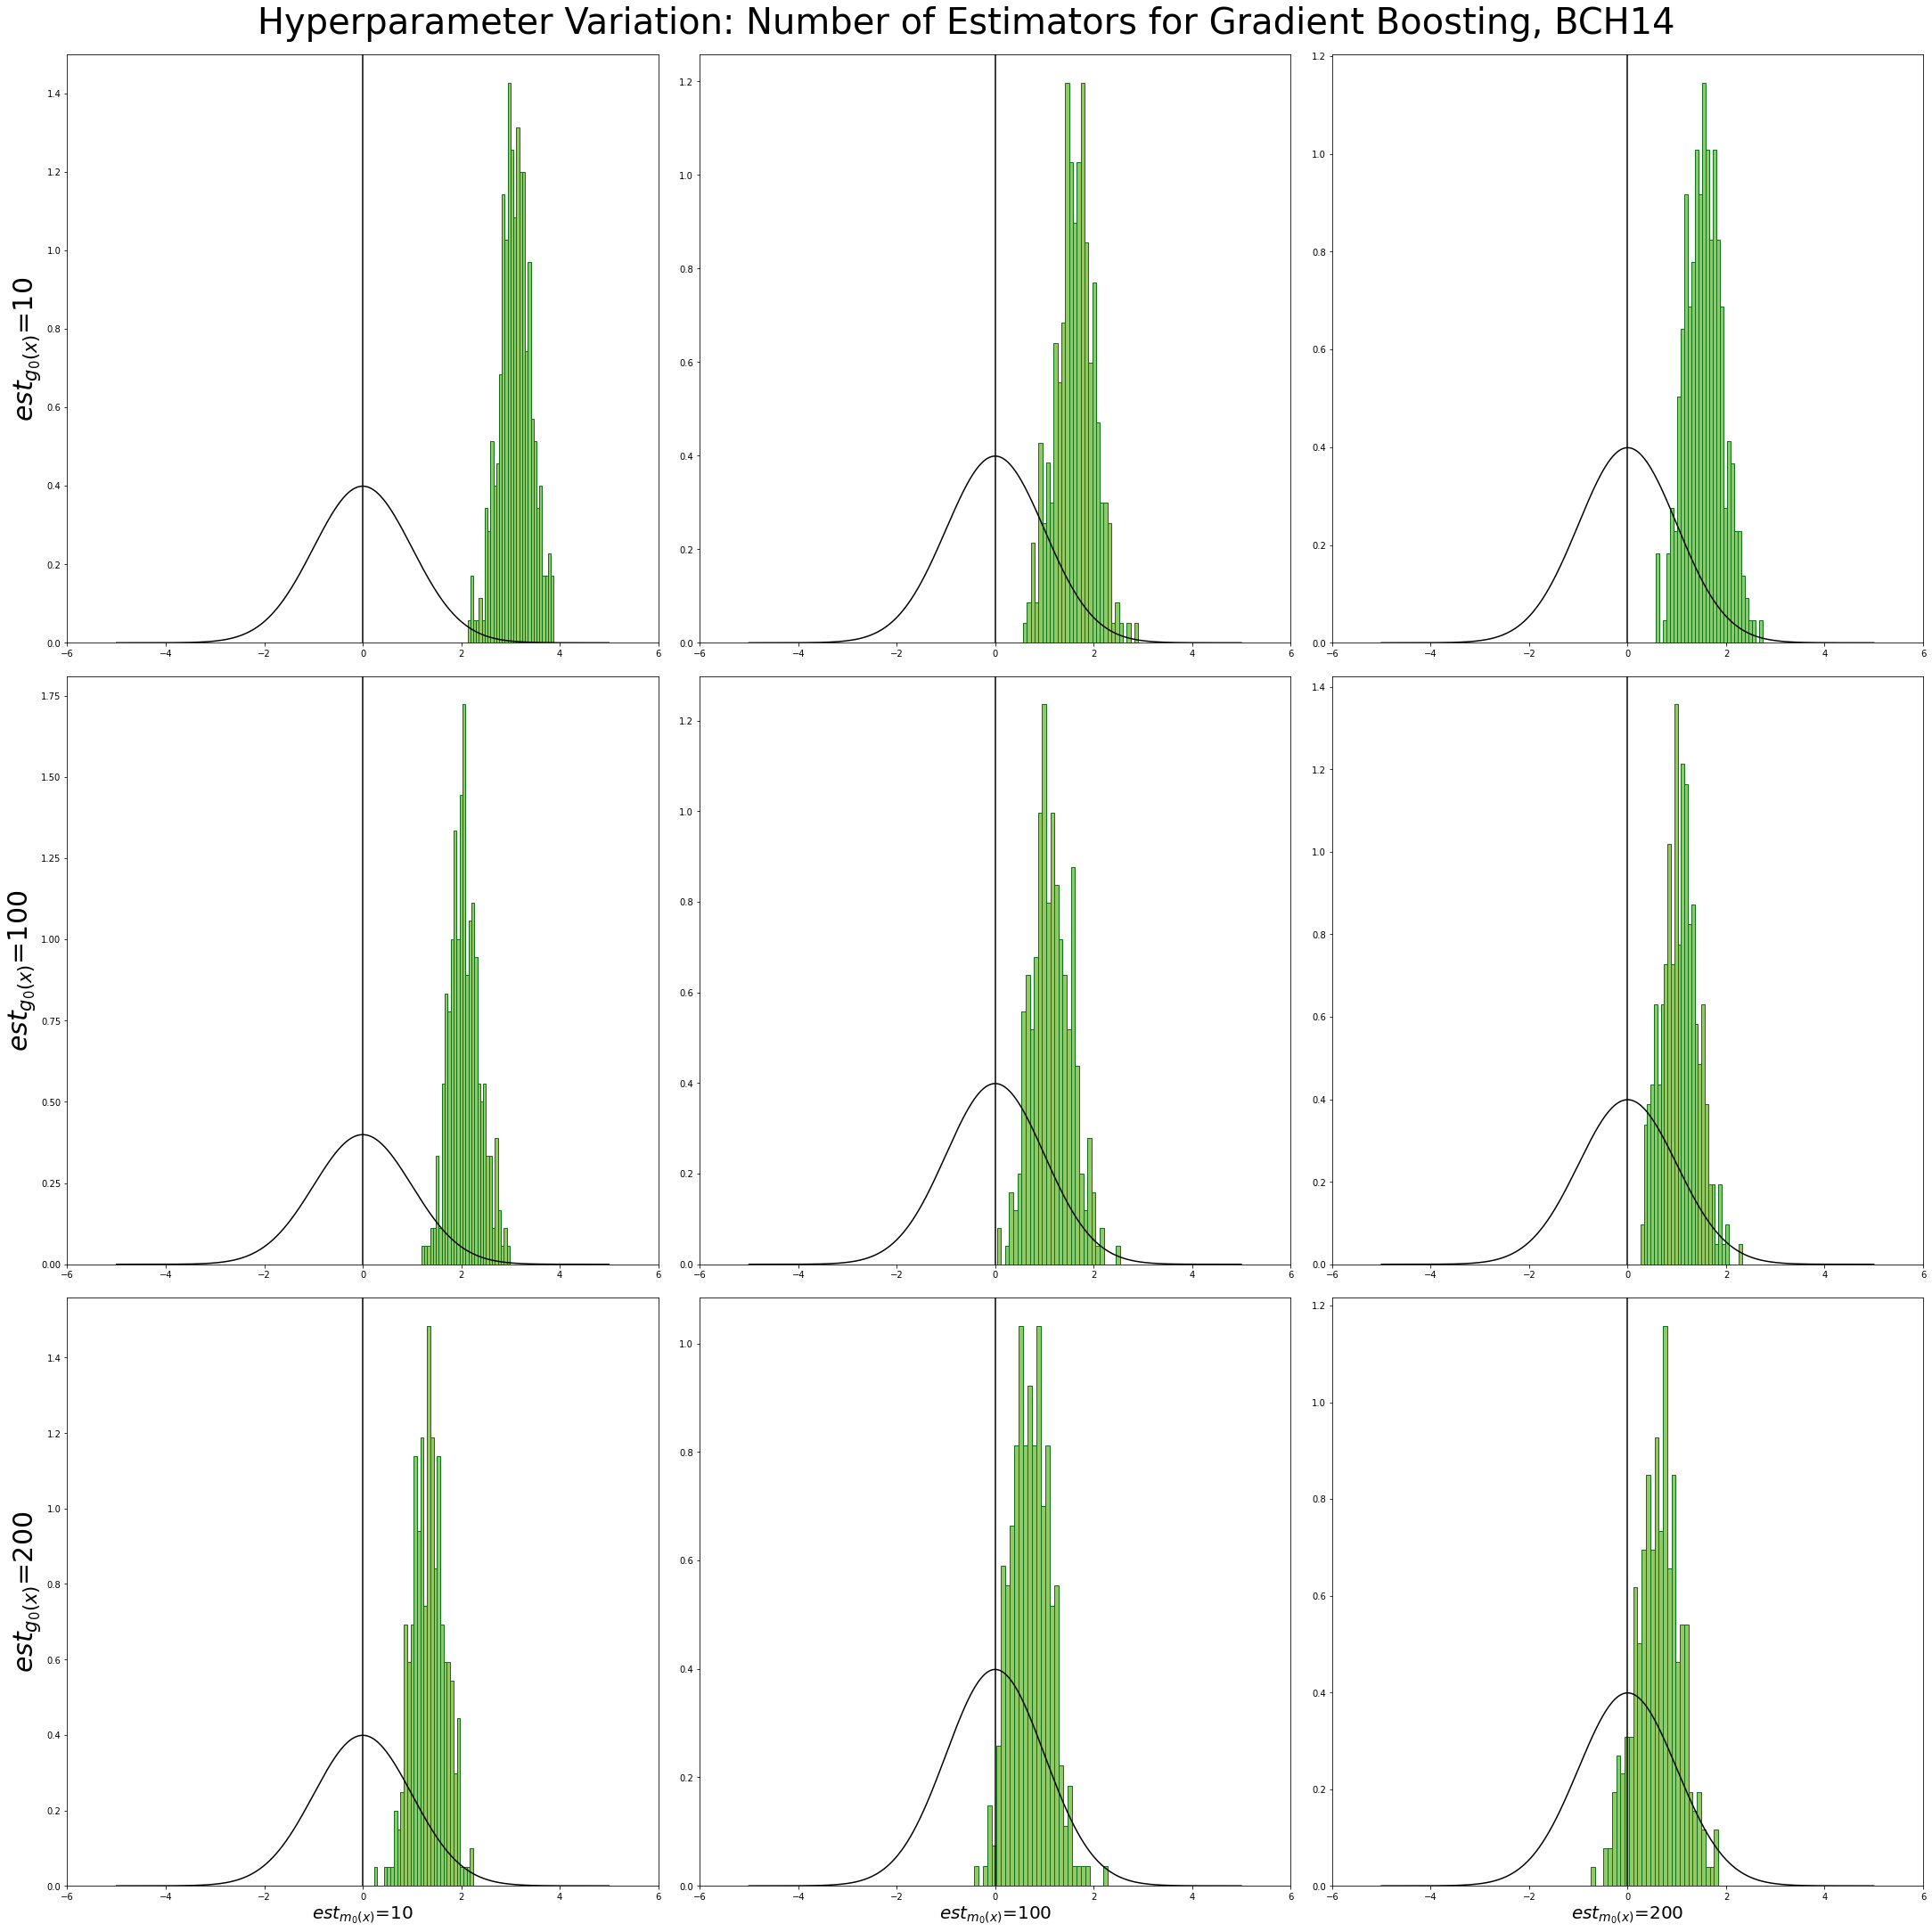

In [17]:
gb_n_est_hyperparams_ml_l_BCH14 = [10, 100, 200]
gb_n_est_hyperparams_ml_m_BCH14 = [10, 100, 200]

n_folds=5

n_est_coverage_BCH14, n_est_bias_BCH14 = plot_gb_plr_variation_results(ml_l_hyperparameters=gb_n_est_hyperparams_ml_l_BCH14,
                                                                       ml_m_hyperparameters=gb_n_est_hyperparams_ml_m_BCH14,
                                                                       n_folds=n_folds, data=data_BCH14, true_alpha=theta_BCH14,
                                                                       tunable_hyperparameter='n_estimators', 
                                                                       ml_l_model=ml_l_plr_gb_model,
                                                                       ml_m_model=ml_m_plr_gb_model,
                                                                       title="Hyperparameter Variation: Number of Estimators for Gradient Boosting, BCH14",
                                                                       xlabels='$est_{m_{0}(x)}$=', ylabel='$est_{g_{0}(x)}$=',
                                                                       filename="gb_number_estimators_variation_BCH14.png")

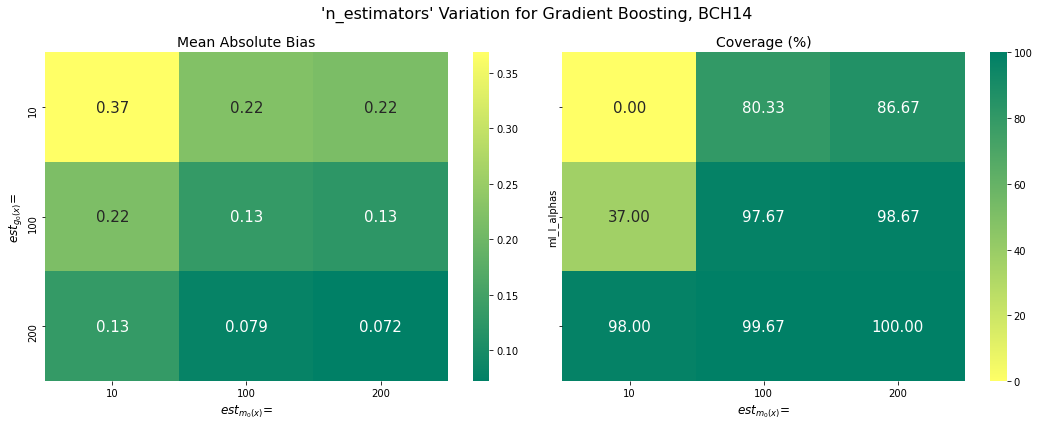

In [18]:
plot_bias_coverage_next_to_eachother(ml_l_hyperparameters=gb_n_est_hyperparams_ml_l_BCH14, 
                                     ml_m_hyperparameters=gb_n_est_hyperparams_ml_m_BCH14,
                                     bias_scores=n_est_bias_BCH14,
                                     coverage_scores=n_est_coverage_BCH14,
                                     suptitle=f"'n_estimators' Variation for Gradient Boosting, BCH14",
                                     xlabel='$est_{m_{0}(x)}$=',
                                     ylabel='$est_{g_{0}(x)}$=',
                                     filename="gb_n_est_bias_coverage_BCH14.png")

## 3.5 BCH2014: Minimum of Samples for Split Variation

Distributions calculated: 1
Distributions calculated: 2
Distributions calculated: 3
Distributions calculated: 4
Distributions calculated: 5
Distributions calculated: 6
Distributions calculated: 7
Distributions calculated: 8
Distributions calculated: 9


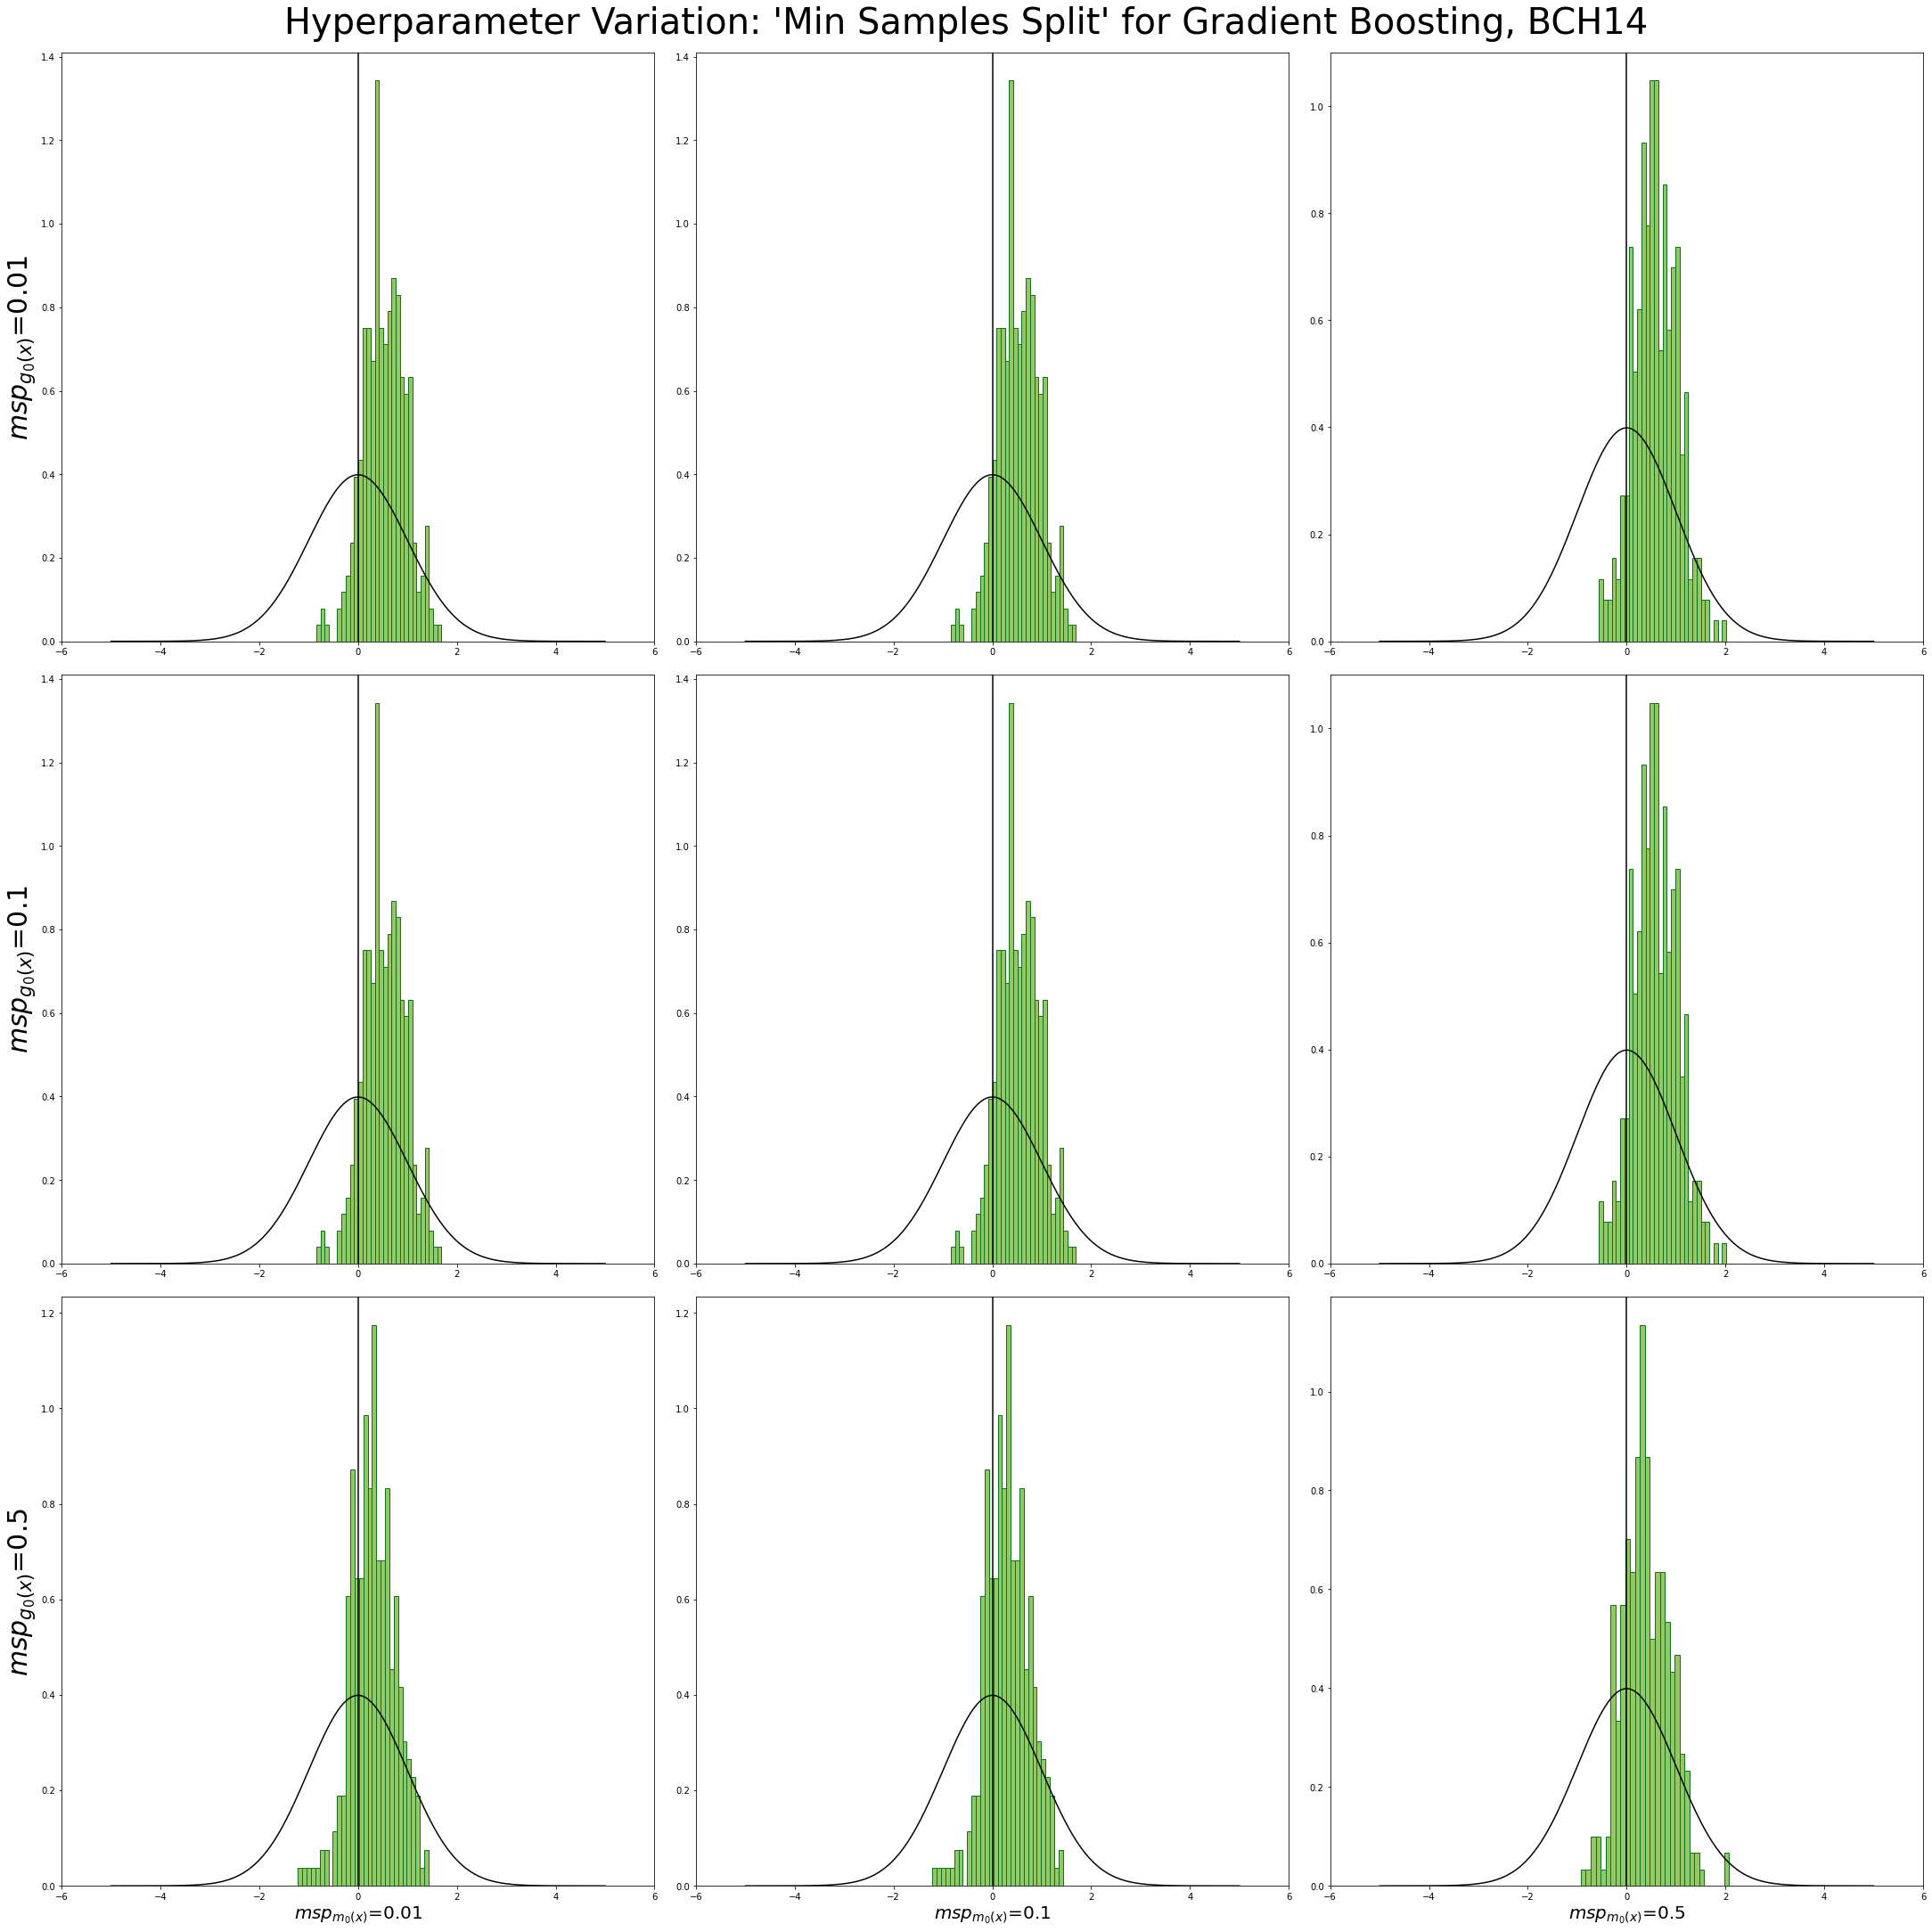

In [19]:
gb_min_samples_split_hyperparams_ml_l_BCH14 = [0.01, 0.1, 0.5]
gb_min_samples_split_hyperparams_ml_m_BCH14 = [0.01, 0.1, 0.5]
n_folds=5

min_sample_split_coverage_BCH14, min_sample_split_bias_BCH14 = plot_gb_plr_variation_results(ml_l_hyperparameters=gb_min_samples_split_hyperparams_ml_l_BCH14,
                                                                                             ml_m_hyperparameters=gb_min_samples_split_hyperparams_ml_m_BCH14,
                                                                                             n_folds=n_folds, data=data_BCH14, true_alpha=theta_BCH14,
                                                                                             tunable_hyperparameter='min_samples_split', 
                                                                                             ml_l_model=ml_l_plr_gb_model,
                                                                                             ml_m_model=ml_m_plr_gb_model,
                                                                                             title="Hyperparameter Variation: 'Min Samples Split' for Gradient Boosting, BCH14",
                                                                                             xlabels='$msp_{m_{0}(x)}$=', ylabel='$msp_{g_{0}(x)}$=',
                                                                                             filename="gb_min_samples_split_variation_BCH14.png")

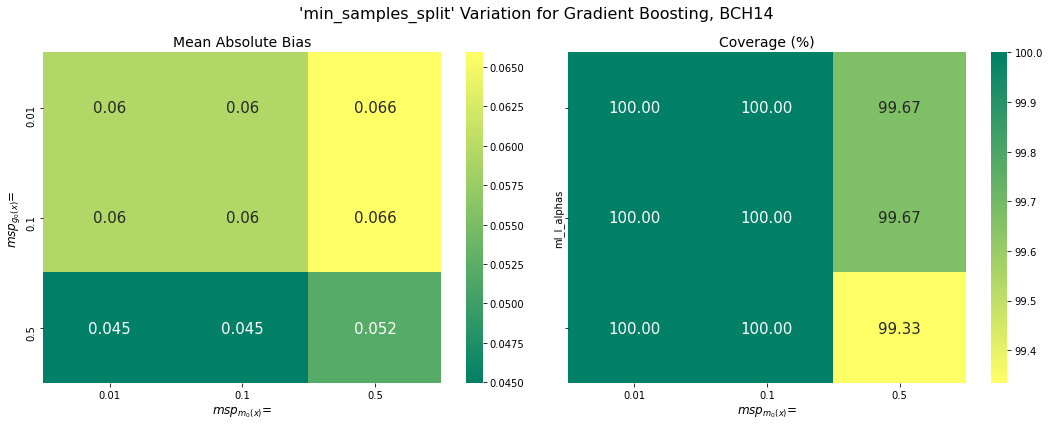

In [20]:
plot_bias_coverage_next_to_eachother(ml_l_hyperparameters=gb_min_samples_split_hyperparams_ml_l_BCH14, 
                                     ml_m_hyperparameters=gb_min_samples_split_hyperparams_ml_m_BCH14,
                                     bias_scores=min_sample_split_bias_BCH14,
                                     coverage_scores=min_sample_split_coverage_BCH14,
                                     suptitle=f"'min_samples_split' Variation for Gradient Boosting, BCH14",
                                     xlabel='$msp_{m_{0}(x)}$=',
                                     ylabel='$msp_{g_{0}(x)}$=',
                                     filename="gb_min_samples_split_bias_coverage_BCH14.png")

## 3.6 BCH2014: Learning Rate Variation

Distributions calculated: 1
Distributions calculated: 2
Distributions calculated: 3
Distributions calculated: 4
Distributions calculated: 5
Distributions calculated: 6
Distributions calculated: 7
Distributions calculated: 8
Distributions calculated: 9


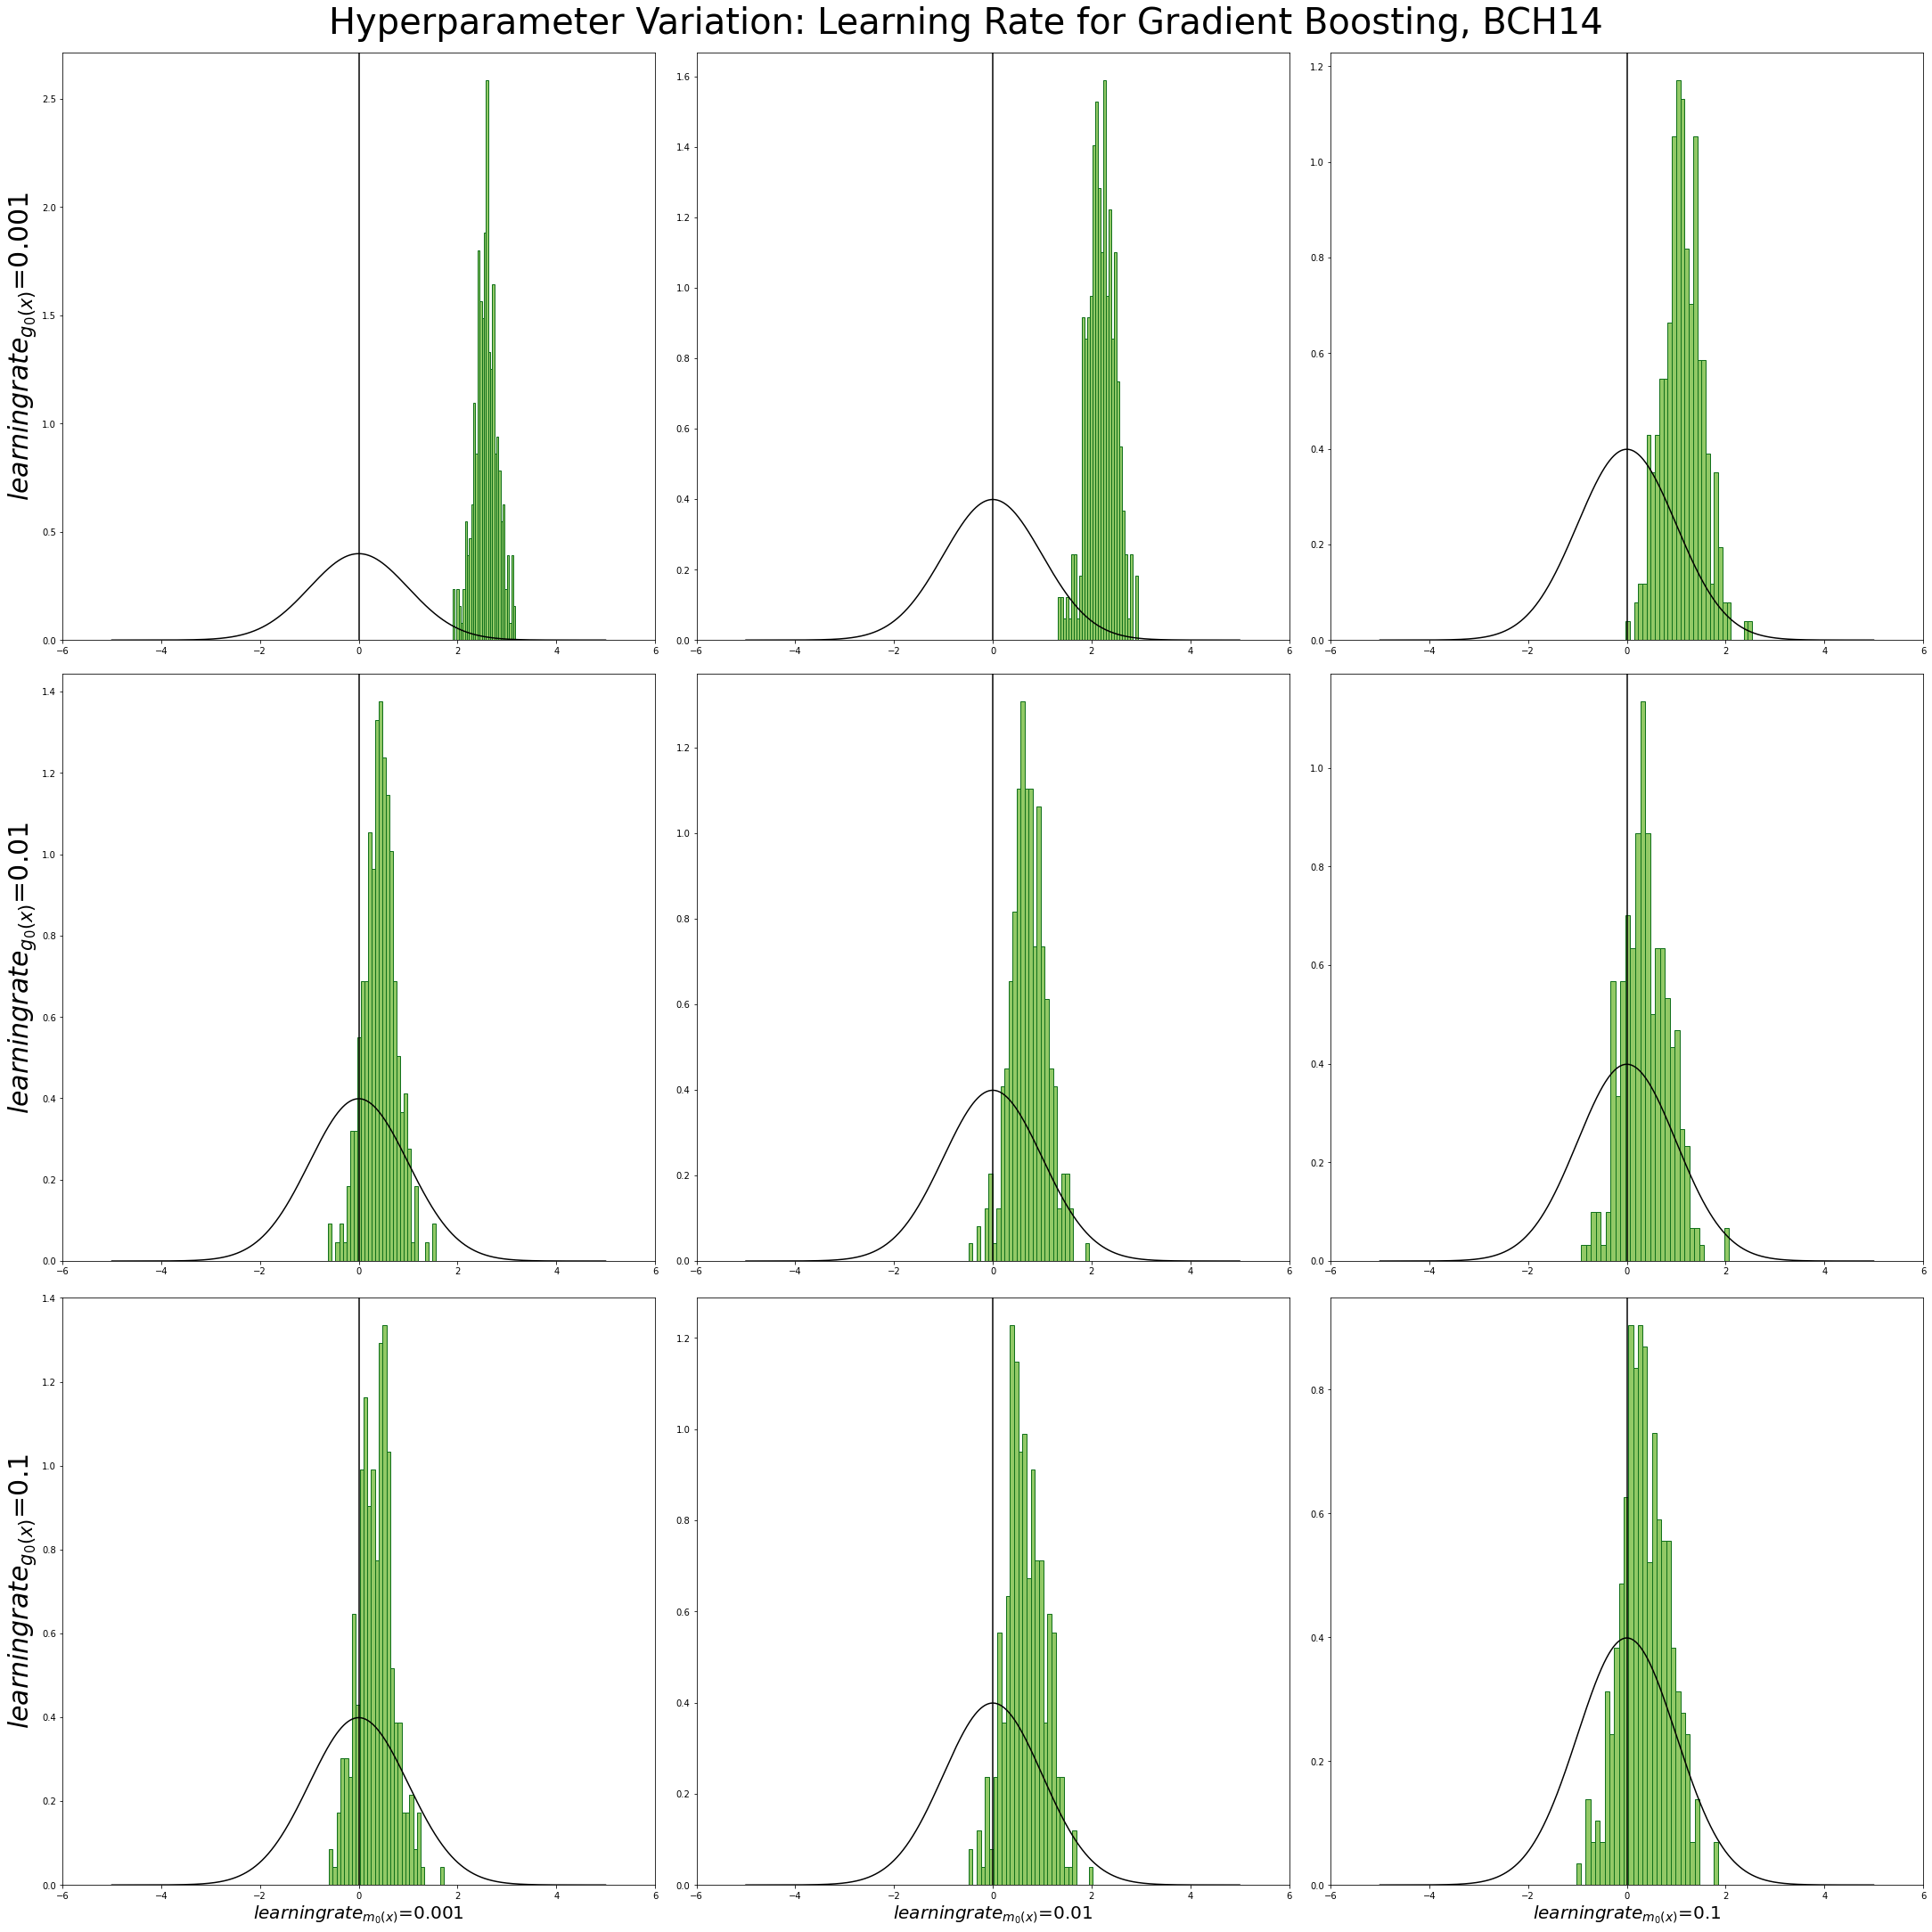

In [21]:
gb_learning_rate_hyperparams_ml_l_BCH14 = [0.001, 0.01, 0.1]
gb_learning_rate_hyperparams_ml_m_BCH14 = [0.001, 0.01, 0.1]
n_folds=5

learningrate_coverage, learningrate_bias = plot_gb_plr_variation_results(ml_l_hyperparameters=gb_learning_rate_hyperparams_ml_l_BCH14,
                                                                         ml_m_hyperparameters=gb_learning_rate_hyperparams_ml_m_BCH14,
                                                                         n_folds=n_folds, data=data_BCH14, true_alpha=theta_BCH14,
                                                                         tunable_hyperparameter='learning_rate', 
                                                                         ml_l_model=ml_l_plr_gb_model,
                                                                         ml_m_model=ml_m_plr_gb_model,
                                                                         title="Hyperparameter Variation: Learning Rate for Gradient Boosting, BCH14",
                                                                         xlabels='$learningrate_{m_{0}(x)}$=', ylabel='$learningrate_{g_{0}(x)}$=',
                                                                         filename="gb_learning_rate_variation_BCH14.png")

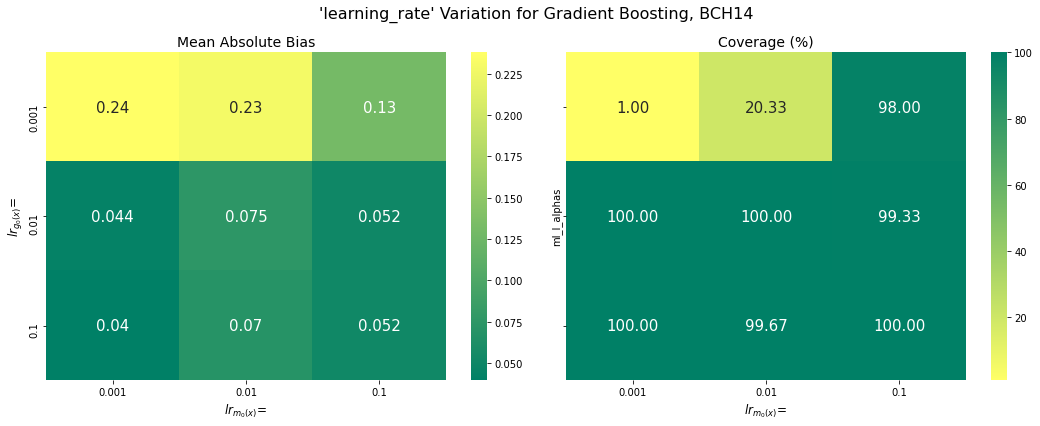

In [22]:
plot_bias_coverage_next_to_eachother(ml_l_hyperparameters=gb_learning_rate_hyperparams_ml_l_BCH14, 
                                     ml_m_hyperparameters=gb_learning_rate_hyperparams_ml_m_BCH14,
                                     bias_scores=learningrate_bias,
                                     coverage_scores=learningrate_coverage,
                                     suptitle=f"'learning_rate' Variation for Gradient Boosting, BCH14",
                                     xlabel='$lr_{m_{0}(x)}$=',
                                     ylabel='$lr_{g_{0}(x)}$=',
                                     filename="gb_learning_rate_split_bias_coverage_BCH14.png")

# 4. IRM Simulation and Hyperparameter Variation

## 4.1 IRM: Number of Estimators Variation

Distributions calculated: 1
Distributions calculated: 2
Distributions calculated: 3
Distributions calculated: 4
Distributions calculated: 5
Distributions calculated: 6
Distributions calculated: 7
Distributions calculated: 8
Distributions calculated: 9


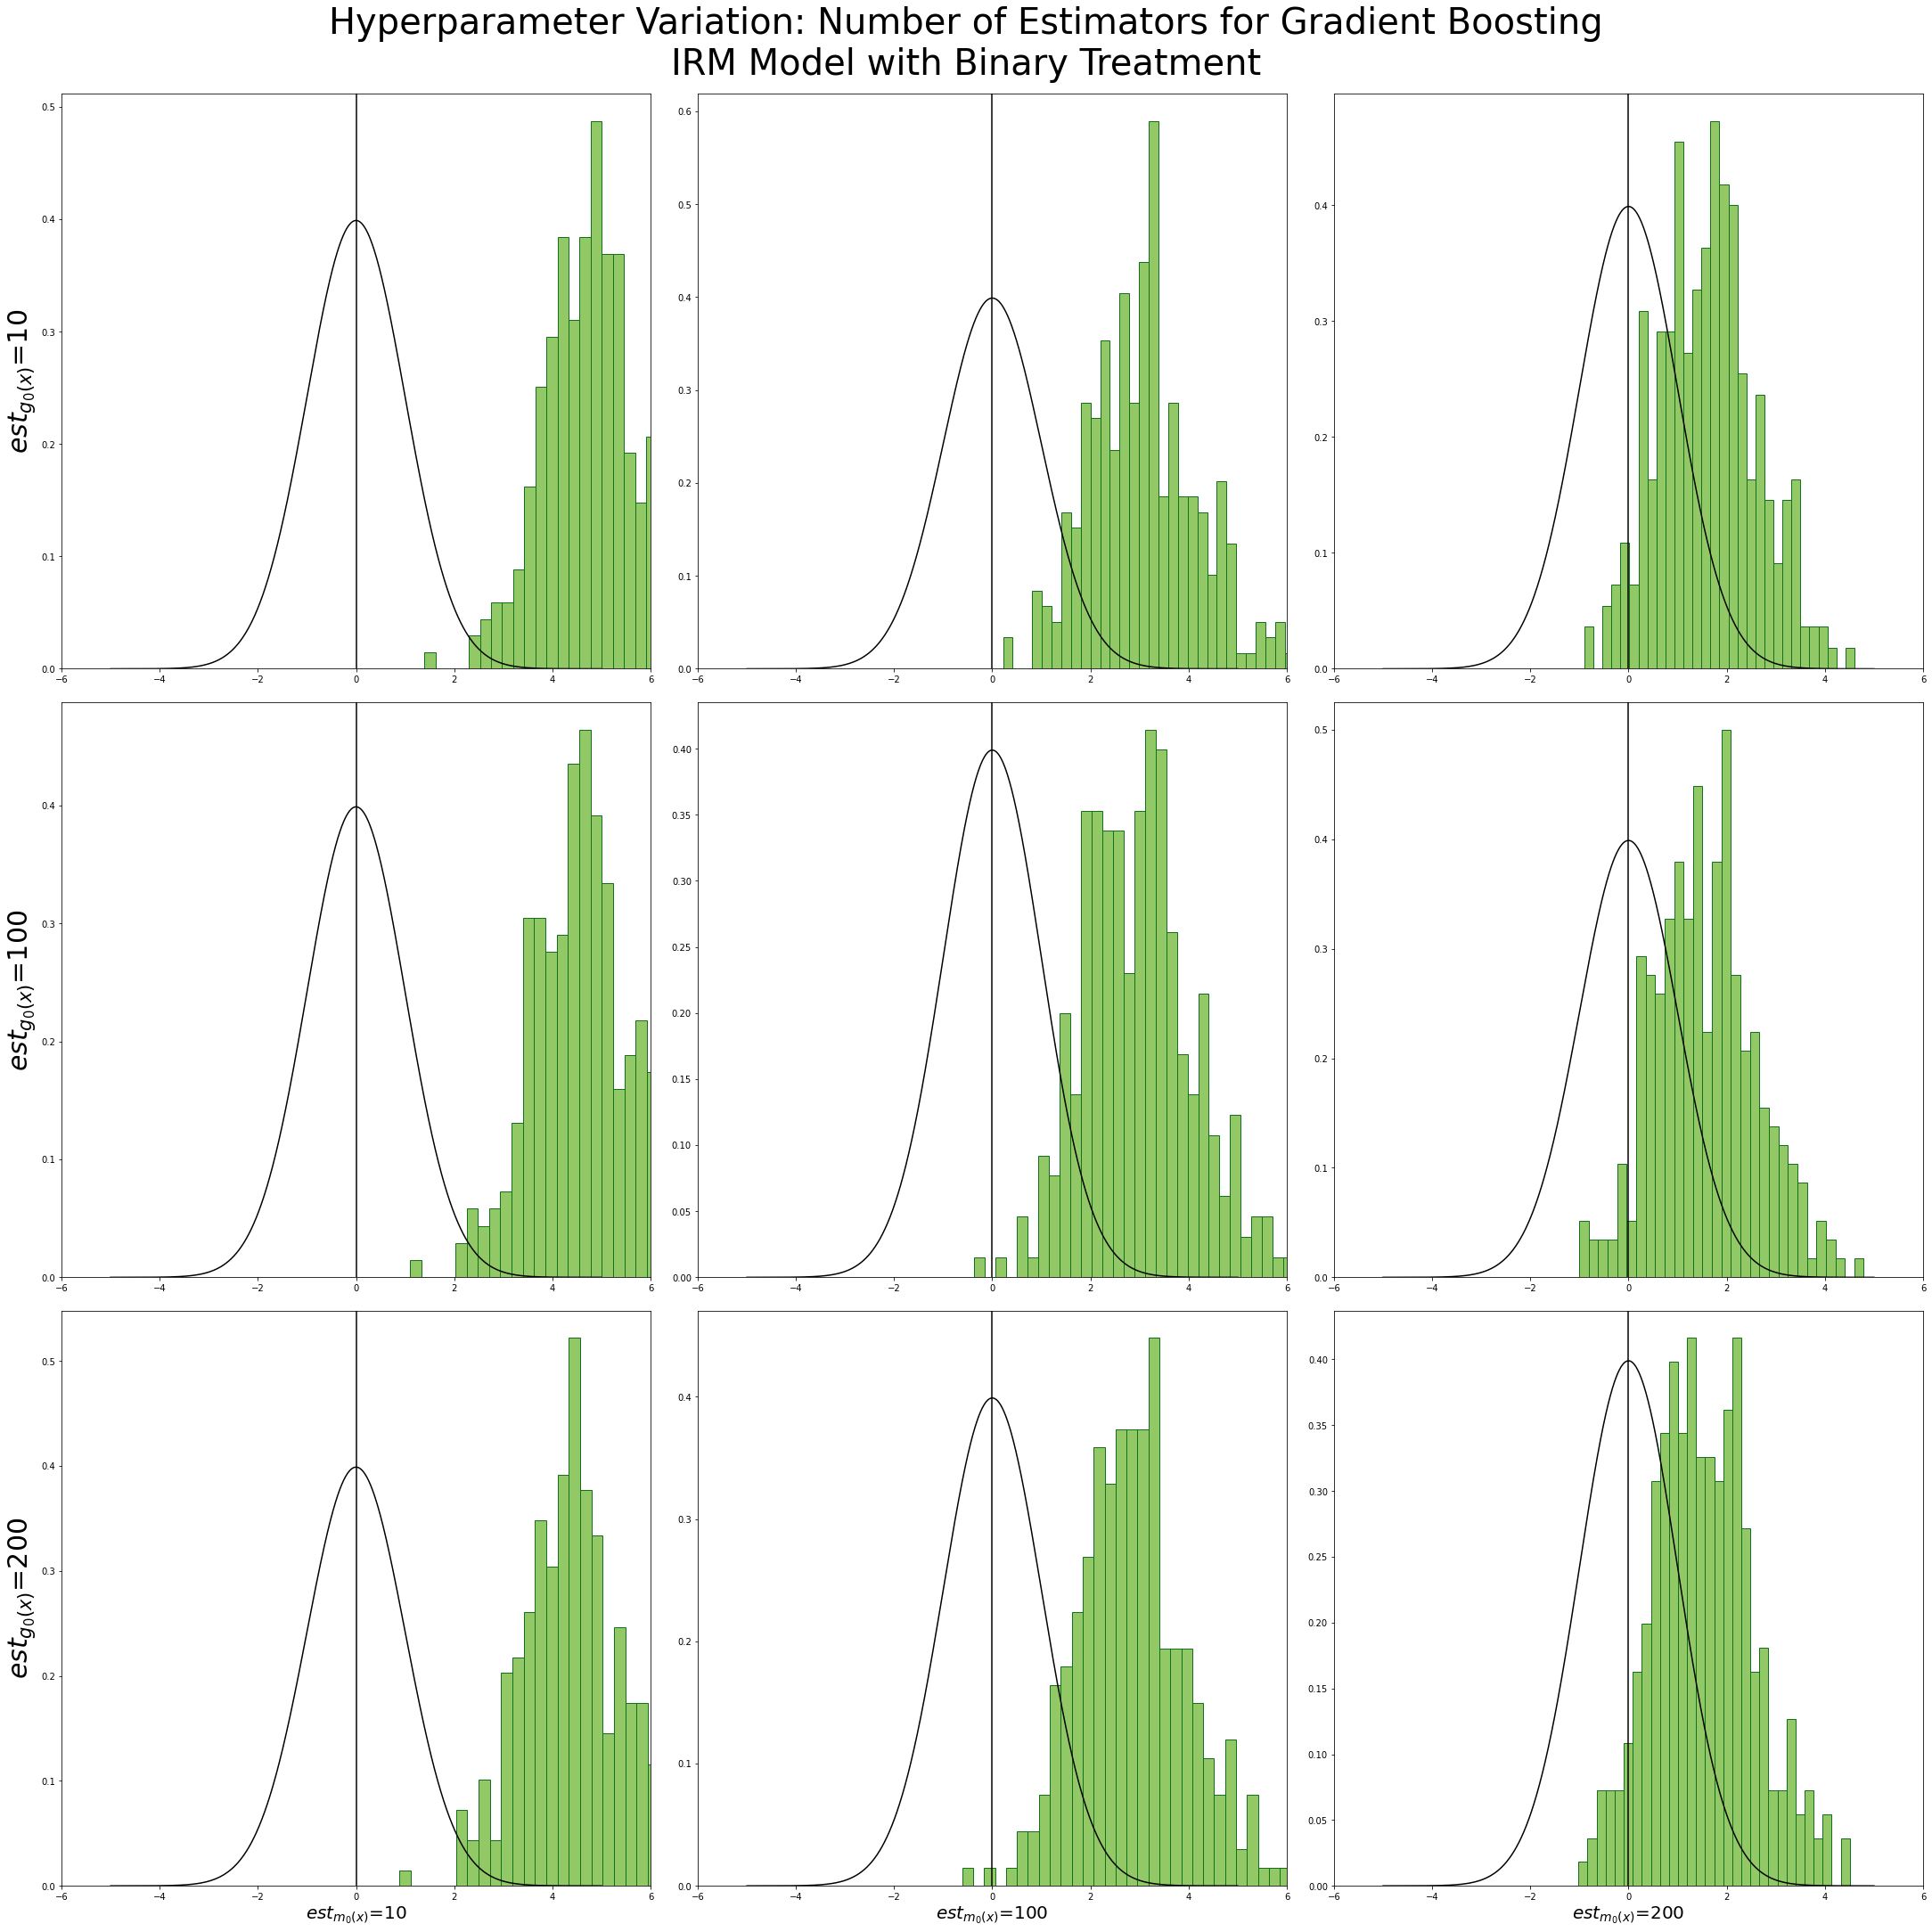

In [23]:
gb_n_est_hyperparams_ml_l_irm = [10, 100, 200]
gb_n_est_hyperparams_ml_m_irm = [10, 100, 200]

n_folds=5

n_est_coverage_IRM, n_est_bias_IRM = plot_gb_irm_variation_results(ml_l_hyperparameters=gb_n_est_hyperparams_ml_l_irm,
                                                           ml_m_hyperparameters=gb_n_est_hyperparams_ml_m_irm,
                                                           n_folds=n_folds, data=irm_data, true_alpha=alpha_irm,
                                                           tunable_hyperparameter='n_estimators', 
                                                           ml_l_model=ml_g0_irm_gb_model,
                                                           ml_m_model=ml_m_irm_gb_model,
                                                           title="Hyperparameter Variation: Number of Estimators for Gradient Boosting\nIRM Model with Binary Treatment",
                                                           xlabels='$est_{m_{0}(x)}$=', ylabel='$est_{g_{0}(x)}$=',
                                                           filename="gb_number_estimators_variation_IRM.png")

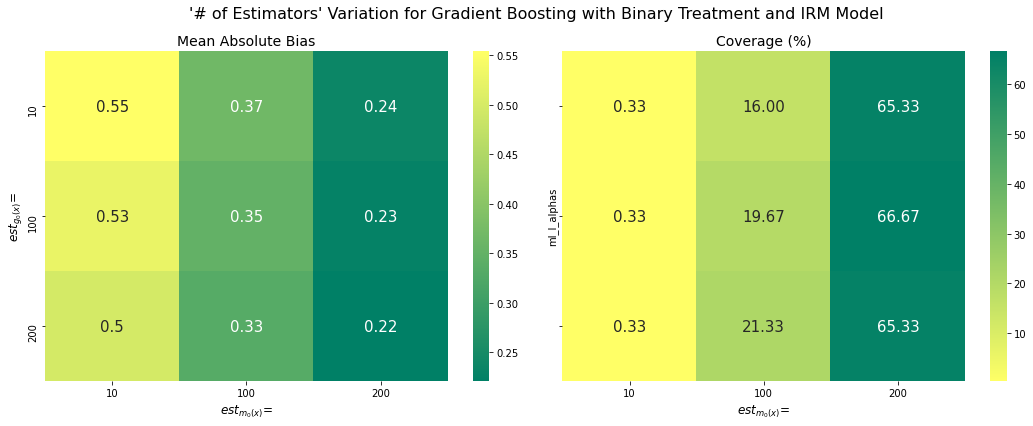

In [24]:
plot_bias_coverage_next_to_eachother(ml_l_hyperparameters=gb_n_est_hyperparams_ml_l_irm, 
                                     ml_m_hyperparameters=gb_n_est_hyperparams_ml_m_irm,
                                     bias_scores=n_est_bias_IRM,
                                     coverage_scores=n_est_coverage_IRM,
                                     suptitle=f"'# of Estimators' Variation for Gradient Boosting with Binary Treatment and IRM Model",
                                     xlabel='$est_{m_{0}(x)}$=',
                                     ylabel='$est_{g_{0}(x)}$=',
                                     filename="gb_n_est_bias_coverage_IRM.png")

## 4.2 IRM Min Samples Split Variation

Distributions calculated: 1
Distributions calculated: 2
Distributions calculated: 3
Distributions calculated: 4
Distributions calculated: 5
Distributions calculated: 6
Distributions calculated: 7
Distributions calculated: 8
Distributions calculated: 9


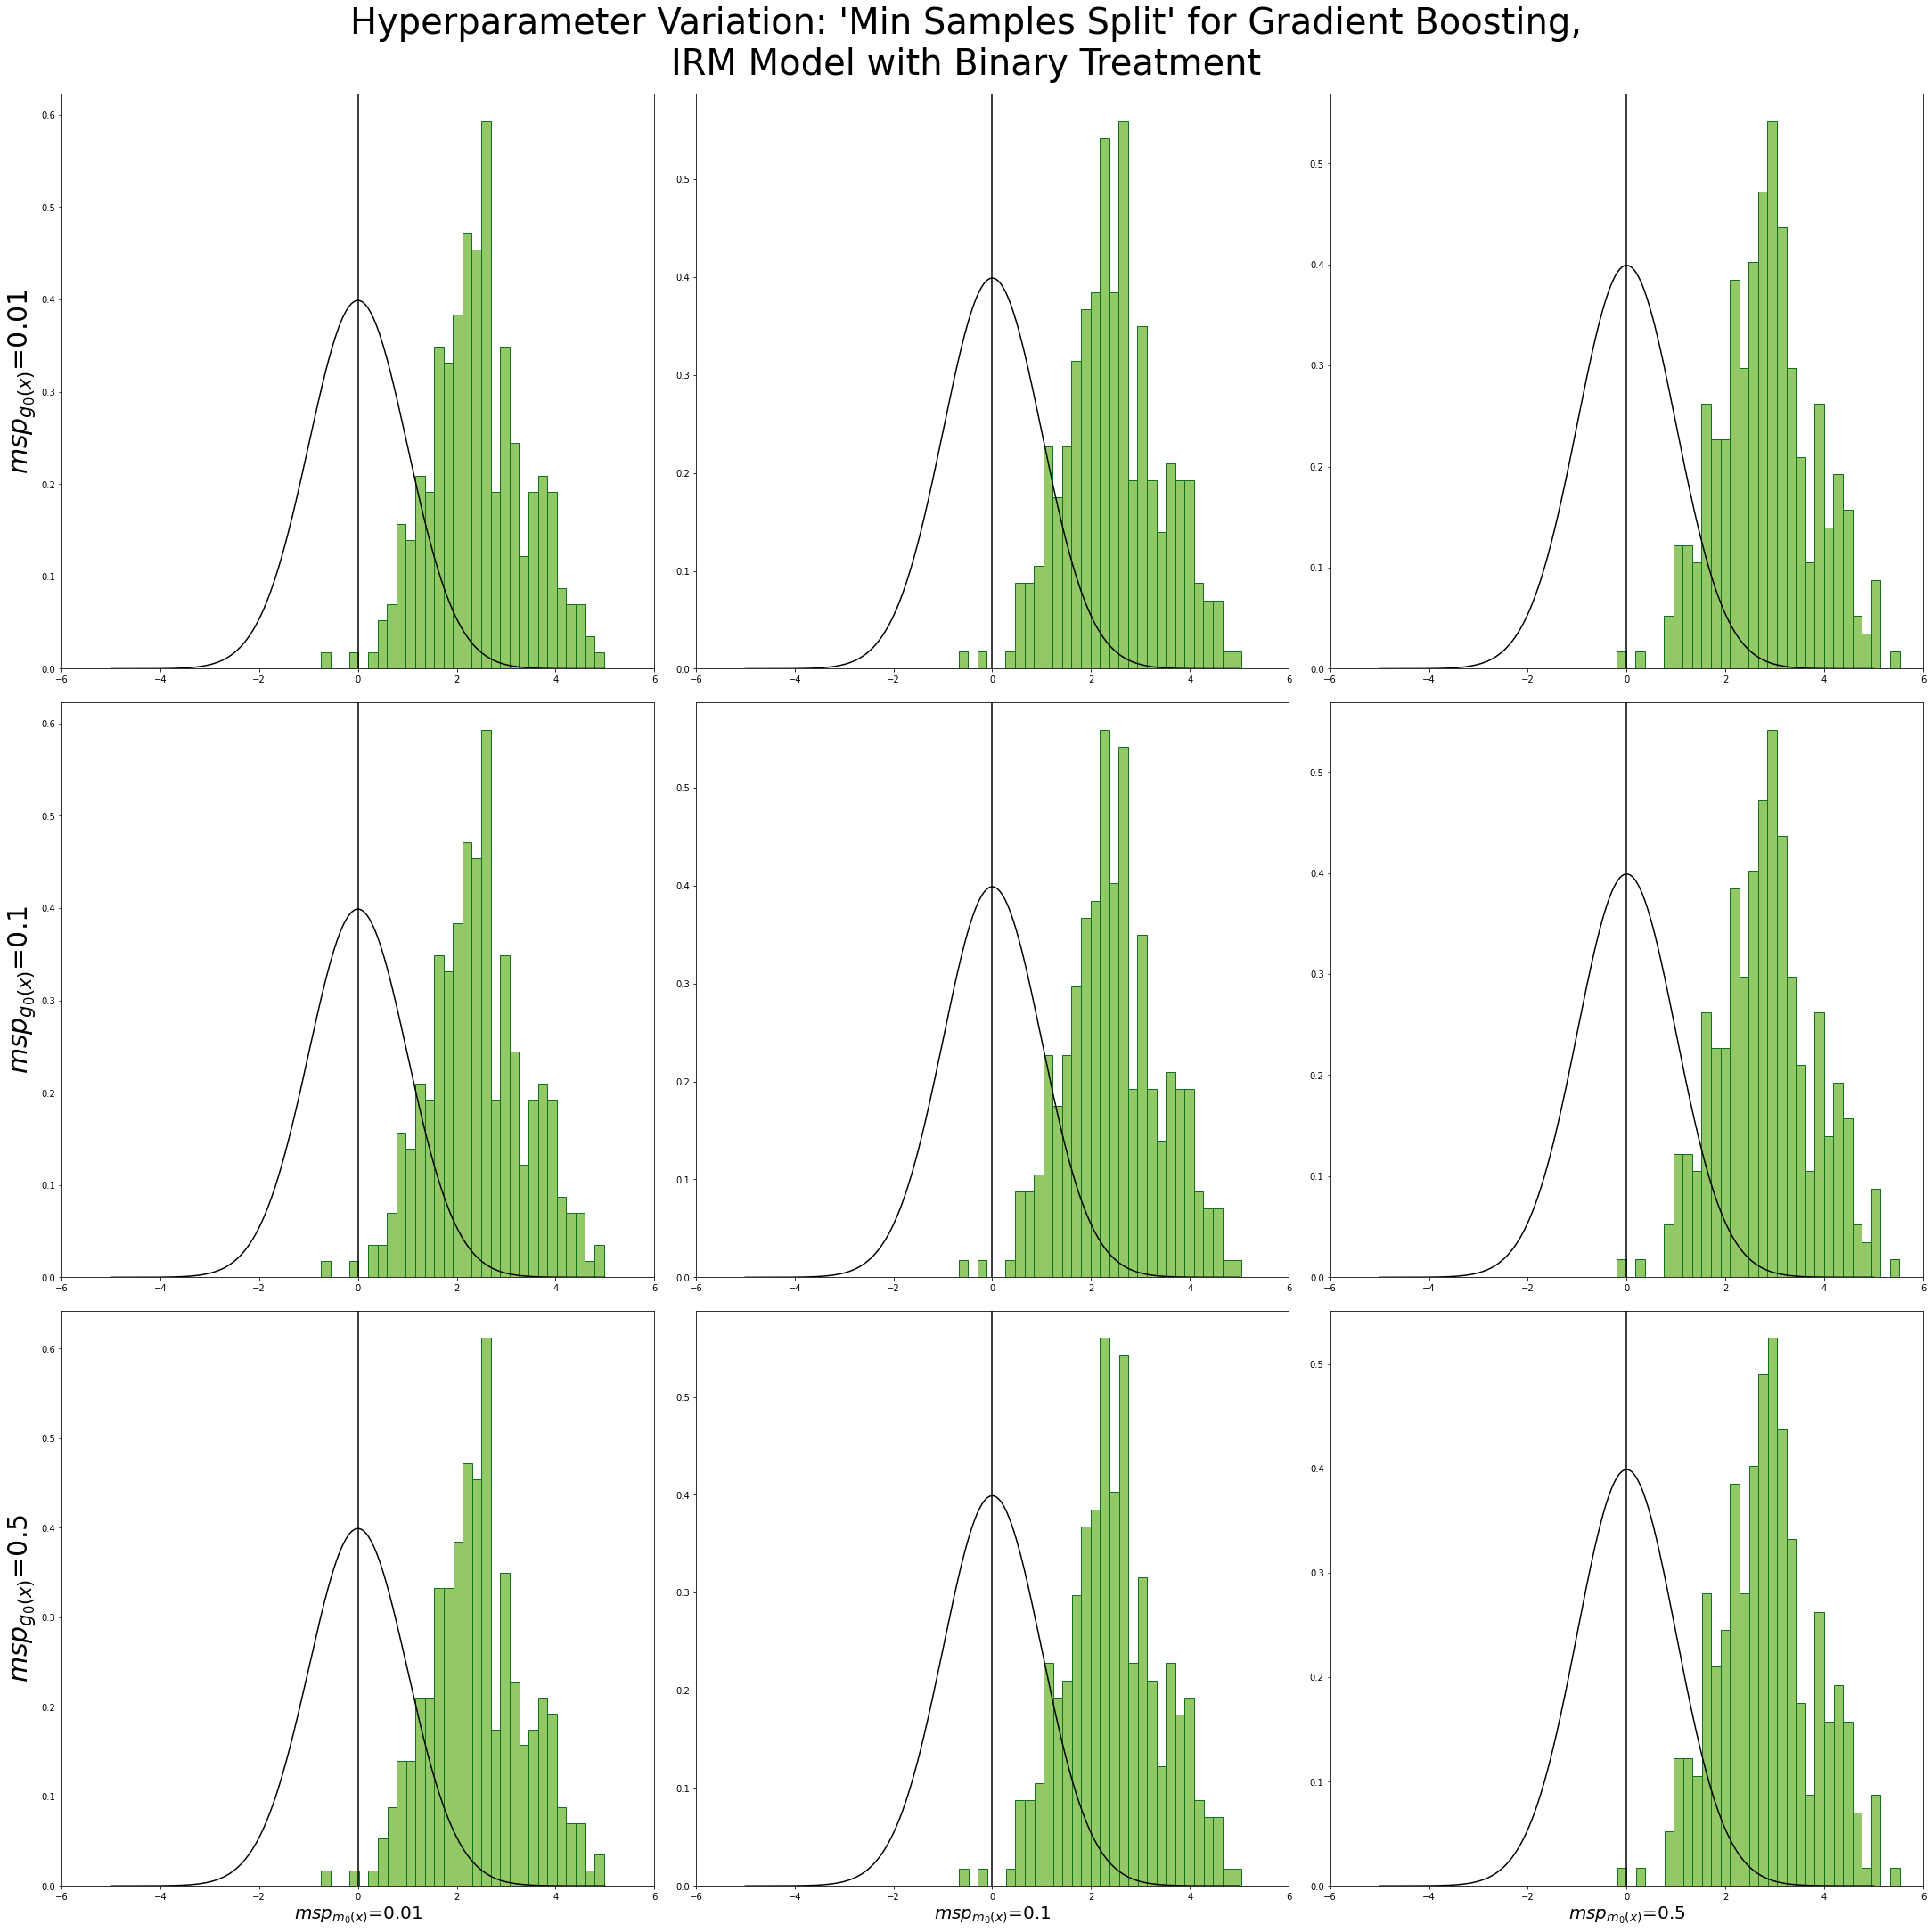

In [25]:
gb_min_samples_split_hyperparams_ml_l_IRM = [0.01, 0.1, 0.5]
gb_min_samples_split_hyperparams_ml_m_IRM = [0.01, 0.1, 0.5]
n_folds=5

min_sample_split_coverage_IRM, min_sample_split_bias_IRM = plot_gb_plr_variation_results(ml_l_hyperparameters=gb_min_samples_split_hyperparams_ml_l_IRM,
                                                                                             ml_m_hyperparameters=gb_min_samples_split_hyperparams_ml_m_IRM,
                                                                                             n_folds=n_folds, data=irm_data, true_alpha=alpha_irm,
                                                                                             tunable_hyperparameter='min_samples_split', 
                                                                                             ml_l_model=ml_g0_irm_gb_model,
                                                                                             ml_m_model=ml_m_irm_gb_model,
                                                                                             title="Hyperparameter Variation: 'Min Samples Split' for Gradient Boosting,\nIRM Model with Binary Treatment",
                                                                                             xlabels='$msp_{m_{0}(x)}$=', ylabel='$msp_{g_{0}(x)}$=',
                                                                                             filename="gb_min_samples_split_variation_IRM.png")

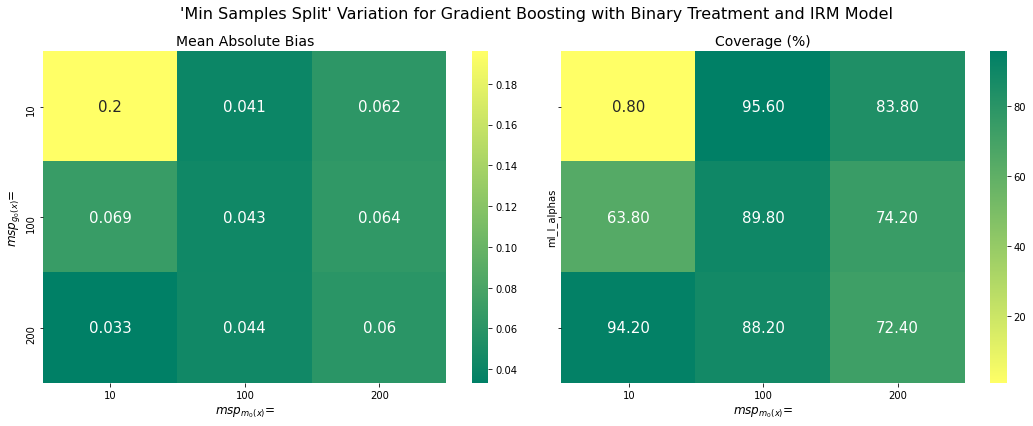

In [26]:
plot_bias_coverage_next_to_eachother(ml_l_hyperparameters=gb_n_est_hyperparams_ml_l_irm, 
                                     ml_m_hyperparameters=gb_n_est_hyperparams_ml_m_irm,
                                     bias_scores=n_est_bias,
                                     coverage_scores=n_est_coverage,
                                     suptitle=f"'Min Samples Split' Variation for Gradient Boosting with Binary Treatment and IRM Model",
                                     xlabel='$msp_{m_{0}(x)}$=',
                                     ylabel='$msp_{g_{0}(x)}$=',
                                     filename="gb_mean_samples_split_bias_coverage_IRM.png")

## 4.3 IRM Learning Rate Variation

Distributions calculated: 1
Distributions calculated: 2
Distributions calculated: 3
Distributions calculated: 4
Distributions calculated: 5
Distributions calculated: 6
Distributions calculated: 7
Distributions calculated: 8
Distributions calculated: 9


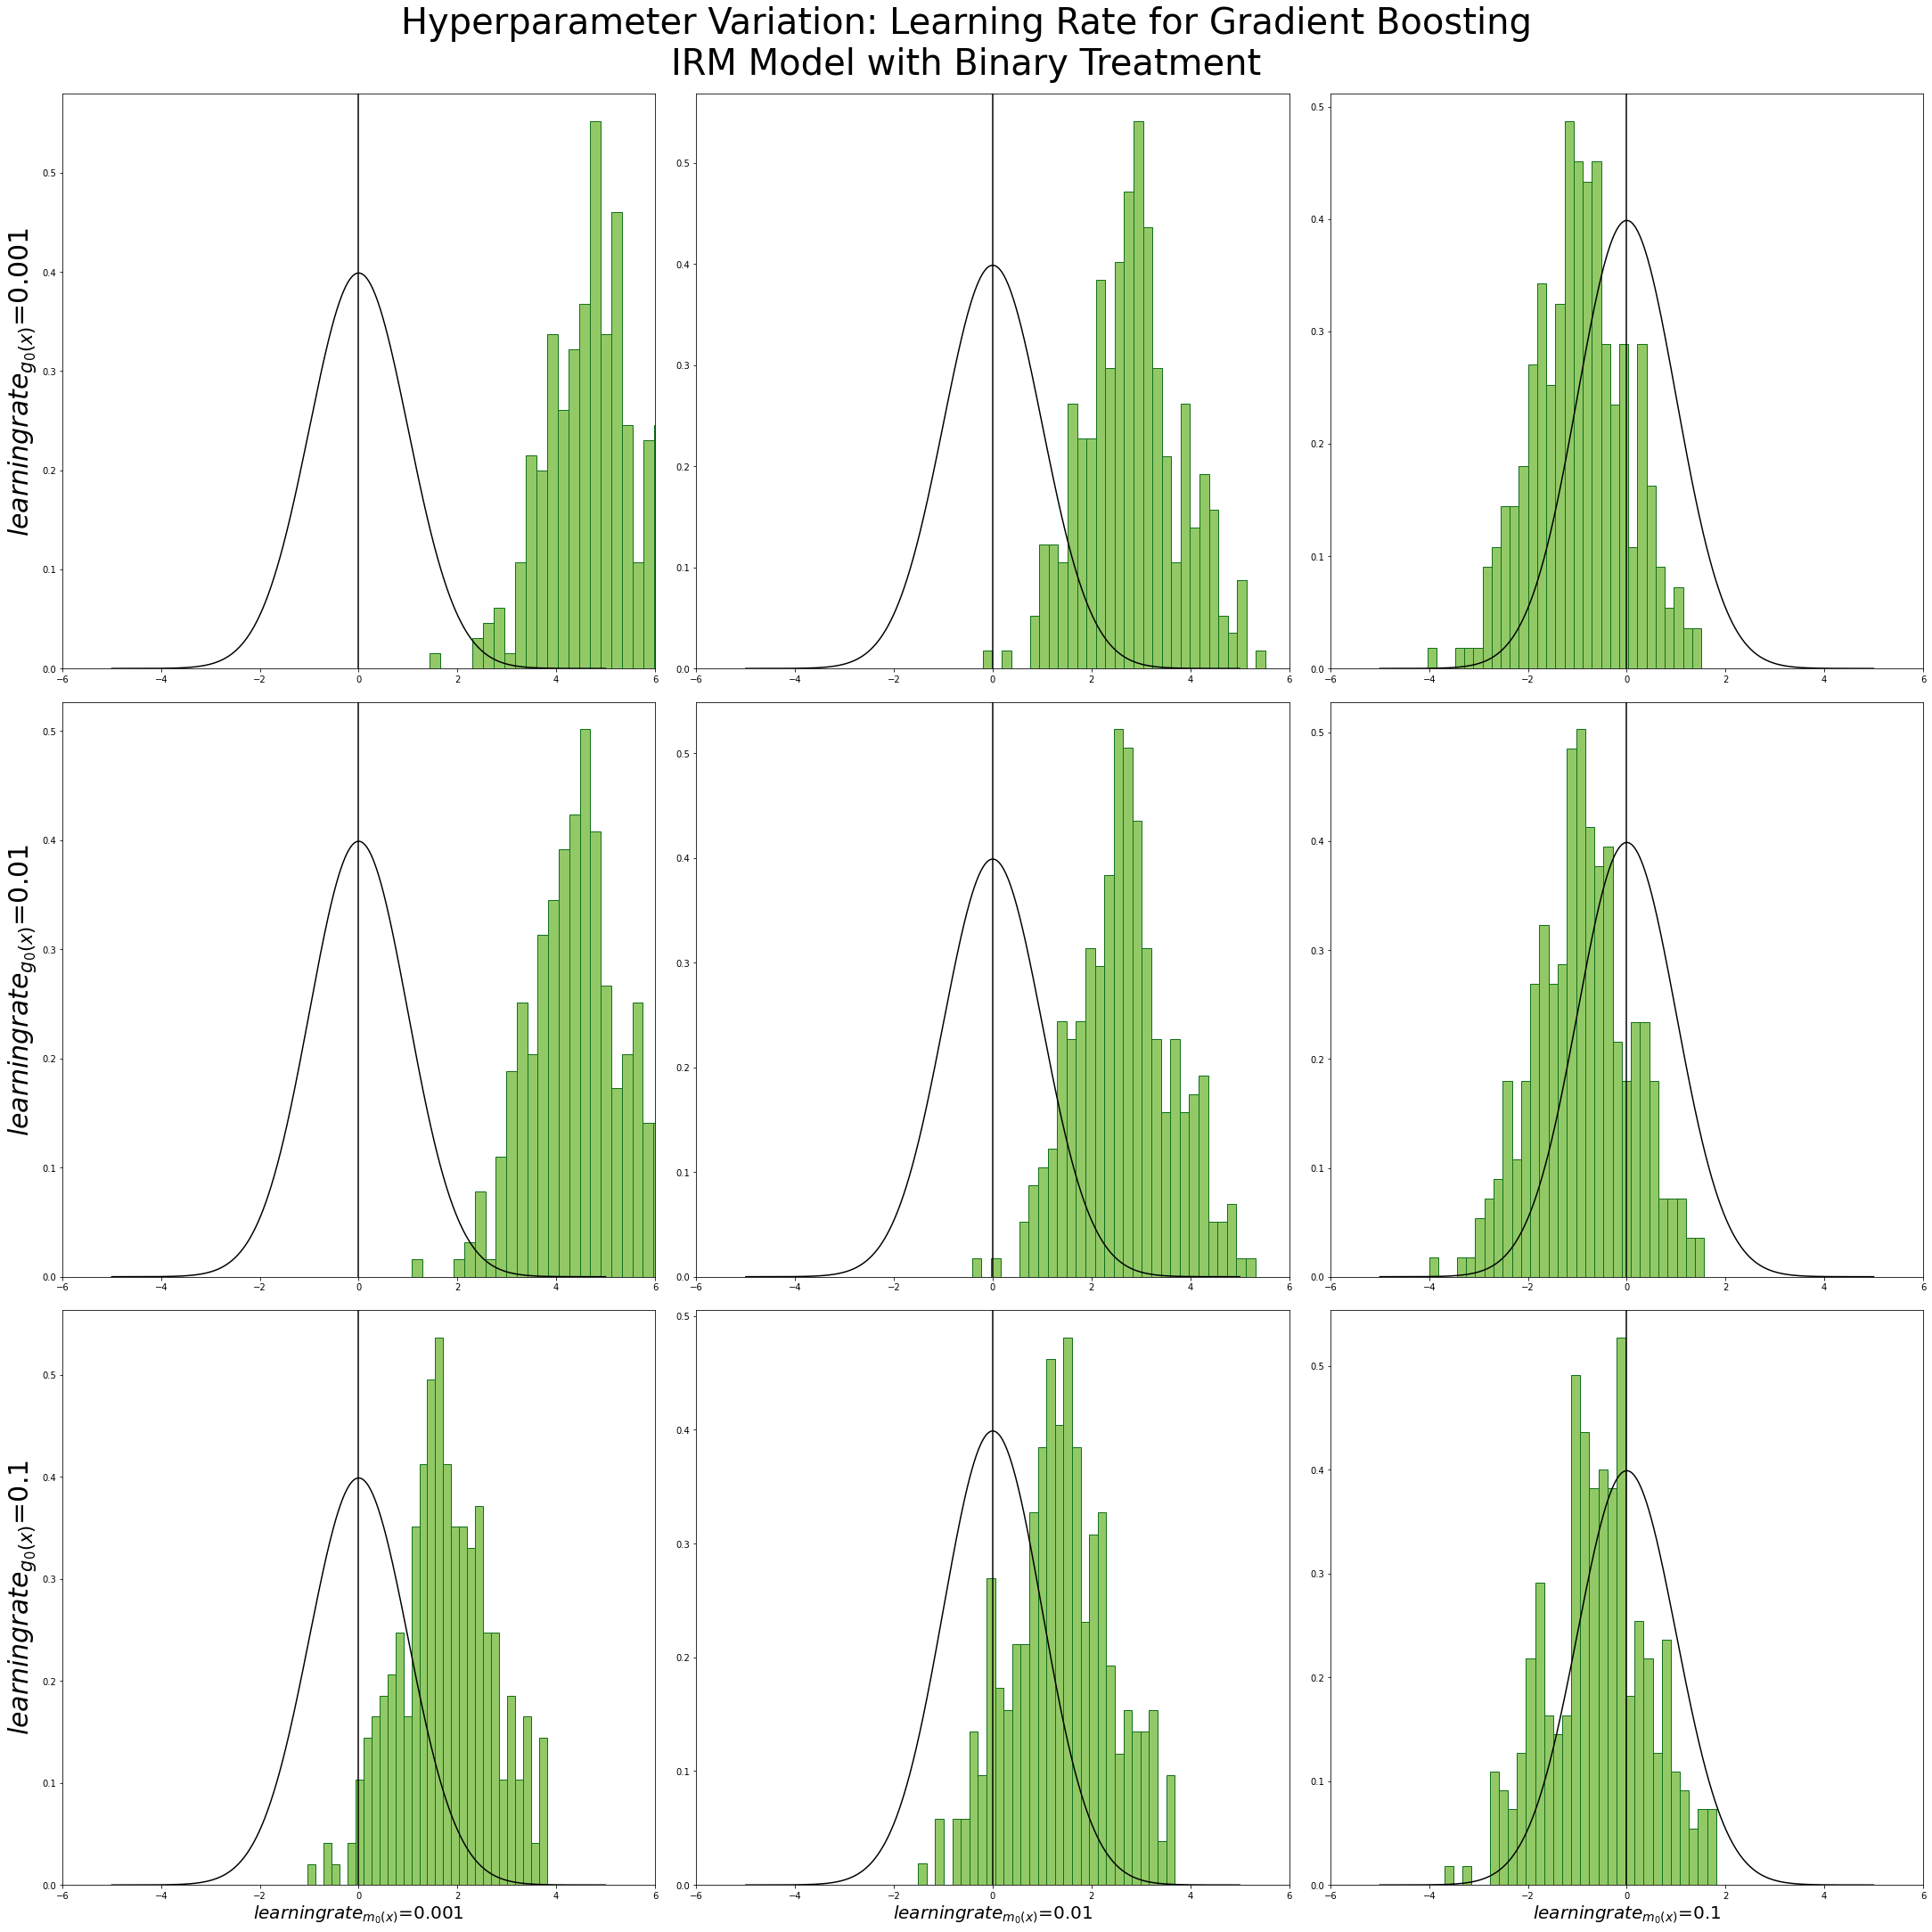

In [27]:
gb_learning_rate_hyperparams_ml_l_IRM = [0.001, 0.01, 0.1]
gb_learning_rate_hyperparams_ml_m_IRM = [0.001, 0.01, 0.1]
n_folds=5

learningrate_coverage_irm, learningrate_bias_irm = plot_gb_plr_variation_results(ml_l_hyperparameters=gb_learning_rate_hyperparams_ml_l_IRM,
                                                                                 ml_m_hyperparameters=gb_learning_rate_hyperparams_ml_m_IRM,
                                                                                 n_folds=n_folds, data=irm_data, true_alpha=alpha_irm,
                                                                                 tunable_hyperparameter='learning_rate', 
                                                                                 ml_l_model=ml_g0_irm_gb_model,
                                                                                 ml_m_model=ml_m_irm_gb_model,
                                                                                 title="Hyperparameter Variation: Learning Rate for Gradient Boosting\nIRM Model with Binary Treatment",
                                                                                 xlabels='$learningrate_{m_{0}(x)}$=', ylabel='$learningrate_{g_{0}(x)}$=',
                                                                                 filename="gb_learning_rate_variation_IRM.png")

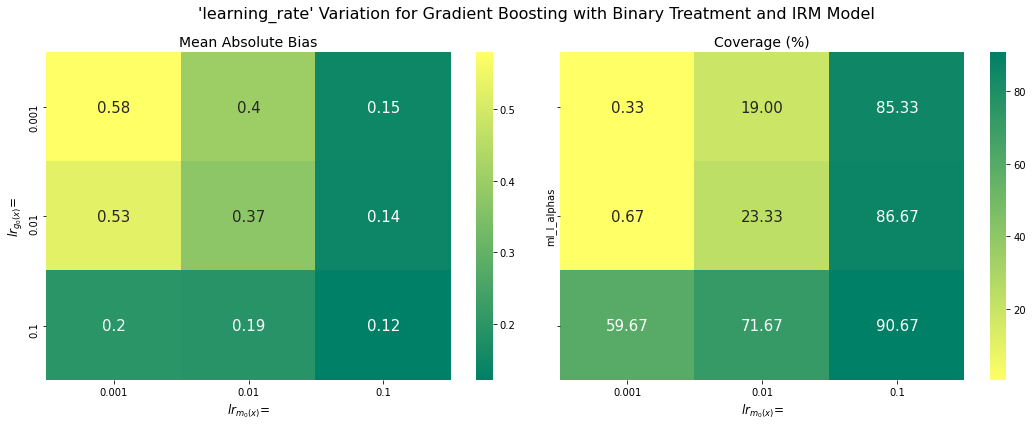

In [28]:
plot_bias_coverage_next_to_eachother(ml_l_hyperparameters=gb_learning_rate_hyperparams_ml_l_IRM, 
                                     ml_m_hyperparameters=gb_learning_rate_hyperparams_ml_m_IRM,
                                     bias_scores=learningrate_bias_irm,
                                     coverage_scores=learningrate_coverage_irm,
                                     suptitle=f"'learning_rate' Variation for Gradient Boosting with Binary Treatment and IRM Model",
                                     xlabel='$lr_{m_{0}(x)}$=',
                                     ylabel='$lr_{g_{0}(x)}$=',
                                     filename="gb_learning_rate_split_bias_coverage_IRM.png")